## Notebook for plotting pareto front of KNN, KNC, & CPD for optimization runs from dimensionality reduction methods

### Data: Figure 1

**Created on 31st December, 2023**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ps.fonttype'] = 42
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as py
import colorsys
import os, sys
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, rdMolDescriptors, Fragments
import optuna
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import rankdata
import scipy
from scipy.spatial.distance import pdist, squareform

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
import plotly.express as px
from IPython.display import SVG, display
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/red-dim-visualization/fig1-data


total 61312
-rw-------@ 1 riteshk  staff   728011 Nov 13 15:14 cond_edb.csv
-rw-------@ 1 riteshk  staff   639778 Nov 13 15:14 cond_edb_ood.csv
-rw-------@ 1 riteshk  staff   905152 Nov 14 13:39 unique_solvent_databases.csv
-rw-------@ 1 riteshk  staff     4144 Nov 17 15:56 ifg.py
drwxr-xr-x  3 riteshk  staff       96 Nov 17 15:56 __pycache__
-rw-r--r--  1 riteshk  staff      630 Nov 26 22:31 tsne_bo.csv
-rw-r--r--@ 1 riteshk  staff  1926601 Nov 27 16:07 tsne_test_ini.png
-rw-r--r--@ 1 riteshk  staff  1712140 Nov 27 16:07 tsne_test_bo.png
-rw-r--r--@ 1 riteshk  staff   185478 Nov 27 16:10 wasserstein_dist_test.png
-rw-------@ 1 riteshk  staff  1033481 Dec 28 19:22 unique_solvent_databases_fgrp_class.csv
-rw-r--r--@ 1 riteshk  staff   377448 Dec 28 19:28 test_tsne_visualization.ipynb
drwx------  8 riteshk  staff      256 Dec 28 20:53 Kobak-2019-Nat-Comm-notebooks
-rw-r--r--@ 1 riteshk  staff   509296 Dec 28 22:02 gen_opt_pca_embedd.ipynb
-rw-r--r--  1 riteshk  staff  1403967 Dec 29 13:3

In [3]:
def find_pareto_front(data):
    """
    Find the Pareto front in a dataset with three properties.
    data: numpy array of shape (n_samples, 3)
    """
    # Initialize a boolean array to mark Pareto optimal points
    is_pareto = np.ones(data.shape[0], dtype=bool)

    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if all(data[j] >= data[i]) and any(data[j] > data[i]):
                # Solution j dominates solution i
                is_pareto[i] = False
                break

    return data[is_pareto], np.where(is_pareto)[0]

In [4]:
def gen_color_gradient(color):
    # Convert the RGB values to HSL
    r, g, b = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    # Decrease the lightness value by 10%
    l -= 0.1 ## + will increase intensity
    # Convert the HSL values back to RGB
    r_, g_, b_ = colorsys.hls_to_rgb(h, l, s)
    return (r_, g_, b_)

**Pareto front for tSNE (openTSNE) trials**

In [14]:
knn_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%12s\n", $9}'
knc_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%12s\n", $10}'
cpd_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%12s\n", $11}'

In [15]:
knn_1 = [float(k.split('[')[1].split(',')[0]) for k in knn_raw]
knc_1 = [float(k_.split(',')[0]) for k_ in knc_raw]
cpd_1 = [float(c.split(']')[0]) for c in cpd_raw]
knn_1

[0.2845007613661083,
 0.24663367413530562,
 0.4645638459865129,
 0.3080269741135523,
 0.5029856428105286,
 0.18850337176419404,
 0.3924787905155536,
 0.010131607570154449,
 0.1973624102675658,
 0.32021427017620185,
 0.21770176201870783,
 0.16169240809223406,
 0.2025505764629106,
 0.41531433543615404,
 0.27295518816619535,
 0.41178485969110284,
 0.33753534914074396,
 0.015537306939308246,
 0.29845007613661084,
 0.33013378290189255,
 0.19986404176636935,
 0.007374374592125299,
 0.2304709593212965,
 0.45559060256689143,
 0.014052643028061779,
 0.2994833587122036,
 0.32388514248422884,
 0.3209973896019143,
 0.4726397650641723,
 0.2872906243202088,
 0.24002610398085705,
 0.4724983685011964,
 0.3858603437024146,
 0.3418044376767457,
 0.2449586686969763,
 0.41746791385686316,
 0.453235805960409,
 0.00775505764629106,
 0.17299869480095714,
 0.258913421796824,
 0.3041929519251686,
 0.26670654774853164,
 0.5130465520991951,
 0.011594518164020014,
 0.2072003480530781,
 0.3836850119643246,
 0.2981

In [16]:
tsne_opentsne = np.array([knn_1, knc_1, cpd_1]).T
tsne_opentsne.shape

(50, 3)

In [10]:
df_tsne_opentsne = pd.DataFrame(tsne_opentsne, columns=['knn_1', 'knc_1', 'cpd_1'])
df_tsne_opentsne.to_csv('df_metric_tsne_opentsne.csv', index=False)

In [5]:
df_tsne_opentsne = pd.read_csv('df_metric_tsne_opentsne.csv')
df_tsne_opentsne

knn       knc       cpd
0   0.284501  0.607143  0.487652
1   0.246634  0.607143  0.534219
2   0.464564  0.678571  0.515721
3   0.308027  0.678571  0.508354
4   0.502986  0.642857  0.480617
5   0.188503  0.571429  0.571880
6   0.392479  0.642857  0.443550
7   0.010132  0.821429  0.095454
8   0.197362  0.607143  0.545518
9   0.320214  0.642857  0.481014
10  0.217702  0.642857  0.554126
11  0.161692  0.571429  0.560701
12  0.202551  0.571429  0.549340
13  0.415314  0.678571  0.431927
14  0.272955  0.678571  0.539112
15  0.411785  0.571429  0.524446
16  0.337535  0.642857  0.446860
17  0.015537  0.678571  0.105809
18  0.298450  0.571429  0.541595
19  0.330134  0.678571  0.529821
20  0.199864  0.571429  0.550369
21  0.007374  0.714286  0.149898
22  0.230471  0.571429  0.543669
23  0.455591  0.678571  0.507555
24  0.014053  0.750000  0.271514
25  0.299483  0.571429  0.552967
26  0.323885  0.678571  0.531112
27  0.320997  0.642857  0.517854
28  0.472640  0.607143  0.415642
29  0.287291  0.607143  0.488533
30  0.240026  0.642857  0.559453
31  0.472498  0.571429  0.452800
32  0.385860  0.571429  0.545234
33  0.341804  0.678571  0.459814
34  0.244959  0.678571  0.549802
35  0.417468  0.678571  0.498198
36  0.453236  0.571429  0.505161
37  0.007755  0.714286  0.110838
38  0.172999  0.571429  0.546210
39  0.258913  0.678571  0.537429
40  0.304193  0.571429  0.558383
41  0.266707  0.571429  0.476782
42  0.513047  0.571429  0.458027
43  0.011595  0.928571  0.104237
44  0.207200  0.607143  0.544204
45  0.383685  0.571429  0.523111
46  0.298107  0.678571  0.528966
47  0.270067  0.642857  0.514061
48  0.257940  0.607143  0.475233
49  0.262503  0.642857  0.461693

In [17]:
pareto_front_tsne_open, indices_tsne_open_tsne = find_pareto_front(tsne_opentsne)
pareto_front_tsne_open

array([[0.46456385, 0.67857143, 0.51572124],
       [0.50298564, 0.64285714, 0.48061715],
       [0.18850337, 0.57142857, 0.57188025],
       [0.27295519, 0.67857143, 0.5391125 ],
       [0.41178486, 0.57142857, 0.5244457 ],
       [0.33013378, 0.67857143, 0.529821  ],
       [0.01405264, 0.75      , 0.27151395],
       [0.32388514, 0.67857143, 0.53111179],
       [0.2400261 , 0.64285714, 0.55945259],
       [0.38586034, 0.57142857, 0.54523385],
       [0.24495867, 0.67857143, 0.54980182],
       [0.30419295, 0.57142857, 0.55838267],
       [0.51304655, 0.57142857, 0.45802694],
       [0.01159452, 0.92857143, 0.10423748]])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


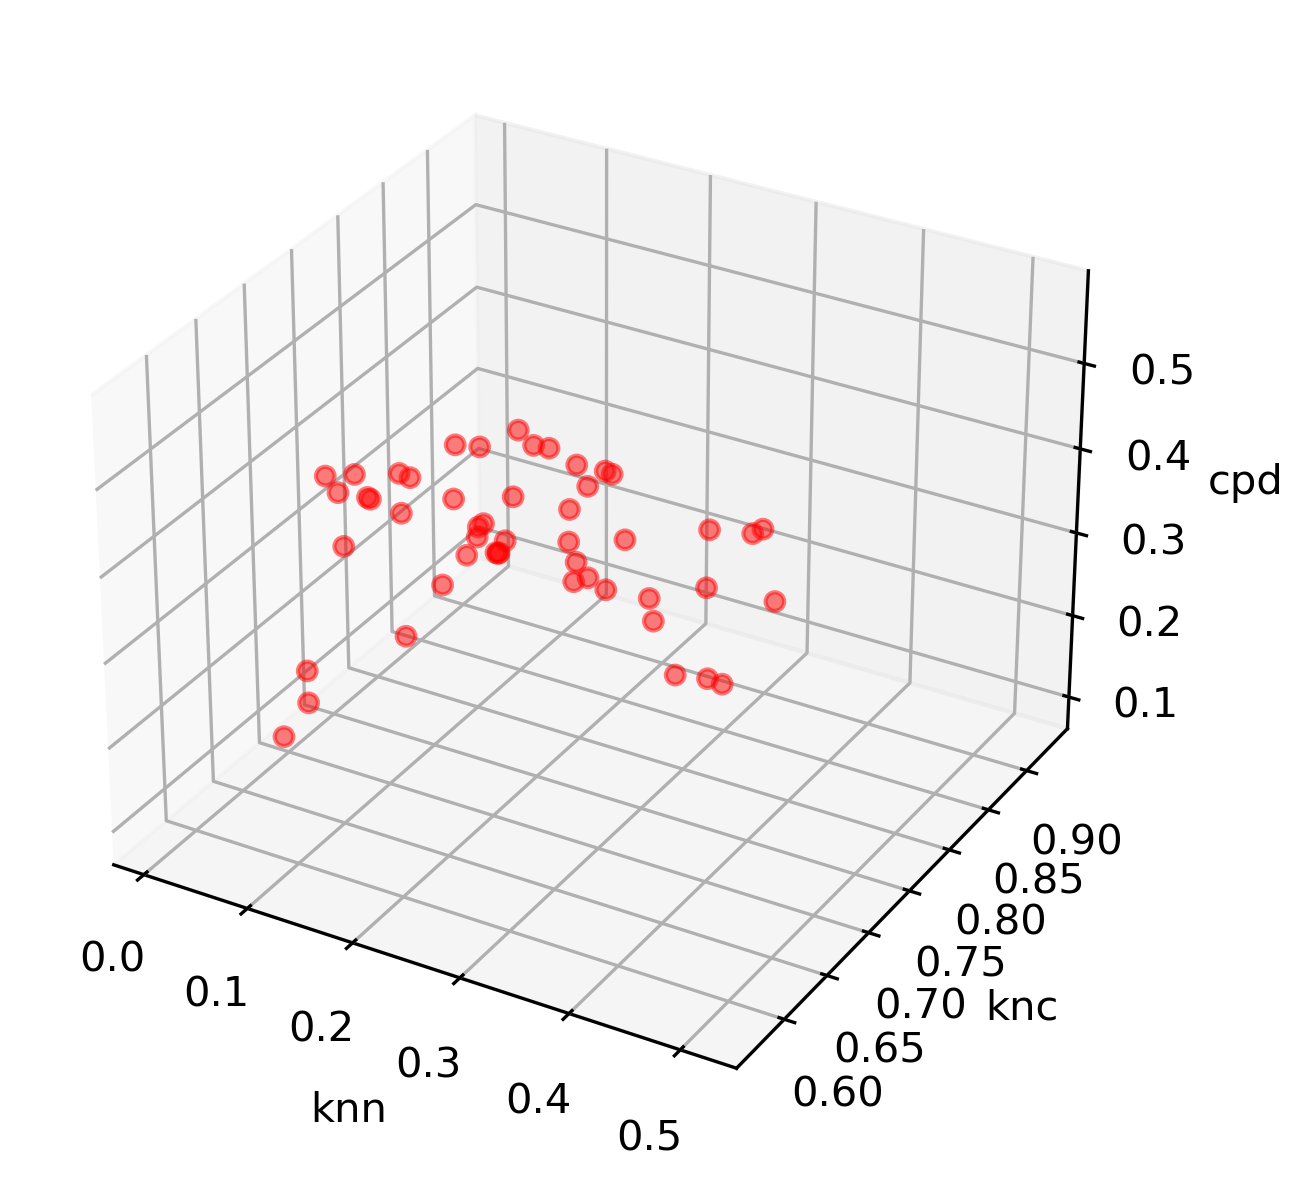

In [12]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(knn_1, knc_1, cpd_1, alpha=0.5, c='r', marker='o')

ax.set_xlabel('knn')
ax.set_ylabel('knc')
ax.set_zlabel('cpd')

plt.show()

In [19]:
fig = go.Figure(data=[go.Scatter3d(
    x=knn_1,
    y=knc_1,
    z=cpd_1,
    mode='markers',
    marker=dict(
        size=6,
        symbol='circle',  # set marker symbol to 'circle'
        color='red',
        opacity=0.8
    ),
    showlegend=False
)])

# Add second scatter plot
fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pareto_front_tsne_open],
    y=[point[1] for point in pareto_front_tsne_open],
    z=[point[2] for point in pareto_front_tsne_open],
    mode='markers',
    marker=dict(
        size=6,
        symbol='circle',  # set marker symbol to 'circle'
        color='blue',
        opacity=0.8
    ),
    showlegend=False
))

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(
            title='knn',
            gridcolor='Black'
        ),
        yaxis=dict(
            title='knc',
            gridcolor='Black'
        ),
        zaxis=dict(
            title='cpd',
            gridcolor='Black'
        ),
        aspectmode='cube'
    ),
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()


**Pareto front for UMAP**

In [131]:
knn_raw = !grep "values:" trial_1_save_umap | awk '{printf "%12s\n", $9}'
knc_raw = !grep "values:" trial_1_save_umap | awk '{printf "%12s\n", $10}'
cpd_raw = !grep "values:" trial_1_save_umap | awk '{printf "%12s\n", $11}'

In [132]:
knn_2 = [float(k.split('[')[1].split(',')[0]) for k in knn_raw]
knc_2 = [float(k_.split(',')[0]) for k_ in knc_raw]
cpd_2 = [float(c.split(']')[0]) for c in cpd_raw]
knn_2

[0.1698770937567979,
 0.1735098977594083,
 0.15368718729606265,
 0.07769741135523167,
 0.023303241244289754,
 0.10171307374374591,
 0.02057319991298673,
 0.0971883837285186,
 0.12565803785077226,
 0.12746900152273222,
 0.12721340004350662,
 0.025407874700891887,
 0.09054274526865347,
 0.14471394387644115,
 0.10232216663041113,
 0.06551011529258212,
 0.08381009353926475,
 0.1257776810963672,
 0.14709049380030453,
 0.12832281922993255,
 0.19872743093321732,
 0.17606591255166412,
 0.1185555797259082,
 0.11822384163584947,
 0.01779421361757668,
 0.14283228192299327,
 0.09890145747226452,
 0.10256145312160106,
 0.146666304111377,
 0.1086306286708723,
 0.11795736349793344,
 0.11289427887752883,
 0.05318686099630193,
 0.018392429845551447,
 0.06512399390907113,
 0.09277246030019579,
 0.11388949314770502,
 0.09607352621274744,
 0.15964215792908418,
 0.12421144224494236,
 0.11056667391777246,
 0.16273656732651728,
 0.10710245812486405,
 0.05665107678921035,
 0.11976832716989341,
 0.076430280617

In [133]:
umap = np.array([knn_2, knc_2, cpd_2]).T
umap.shape

(50, 3)

In [28]:
df_umap = pd.DataFrame(umap, columns=['knn_2', 'knc_2', 'cpd_2'])
df_umap.to_csv('df_metric_umap.csv', index=False)

In [128]:
df_umap = pd.read_csv('df_metric_umap.csv')
df_umap

knn_2     knc_2     cpd_2
0   0.169877  0.571429  0.493172
1   0.173510  0.571429  0.486426
2   0.153687  0.678571  0.465358
3   0.077697  0.642857  0.499488
4   0.023303  0.607143  0.309074
5   0.101713  0.607143  0.507991
6   0.020573  0.678571  0.282091
7   0.097188  0.607143  0.485481
8   0.125658  0.607143  0.474526
9   0.127469  0.678571  0.530428
10  0.127213  0.607143  0.471681
11  0.025408  0.642857  0.281316
12  0.090543  0.642857  0.471879
13  0.144714  0.678571  0.470099
14  0.102322  0.607143  0.409750
15  0.065510  0.678571  0.468227
16  0.083810  0.678571  0.427293
17  0.125778  0.642857  0.505083
18  0.147090  0.750000  0.530267
19  0.128323  0.571429  0.482240
20  0.198727  0.642857  0.452594
21  0.176066  0.678571  0.535898
22  0.118556  0.714286  0.447766
23  0.118224  0.607143  0.536251
24  0.017794  0.607143  0.241708
25  0.142832  0.607143  0.494654
26  0.098901  0.642857  0.506202
27  0.102561  0.678571  0.508826
28  0.146666  0.607143  0.506081
29  0.108631  0.678571  0.416455
30  0.117957  0.642857  0.532763
31  0.112894  0.607143  0.527864
32  0.053187  0.571429  0.449999
33  0.018392  0.750000  0.189904
34  0.065124  0.785714  0.463723
35  0.092772  0.607143  0.481149
36  0.113889  0.678571  0.439646
37  0.096074  0.607143  0.444417
38  0.159642  0.642857  0.528103
39  0.124211  0.607143  0.478779
40  0.110567  0.607143  0.512461
41  0.162737  0.607143  0.487832
42  0.107102  0.571429  0.474465
43  0.056651  0.678571  0.475346
44  0.119768  0.642857  0.518958
45  0.076430  0.642857  0.435183
46  0.155226  0.714286  0.530941
47  0.137840  0.678571  0.526177
48  0.182075  0.678571  0.434203
49  0.131058  0.607143  0.536431

In [134]:
pareto_front_umap, indices_umap = find_pareto_front(umap)
# pareto_front_umap, indices_umap = find_pareto_front(df_umap) # this is not working
pareto_front_umap

array([[0.14709049, 0.75      , 0.53026699],
       [0.19872743, 0.64285714, 0.4525941 ],
       [0.17606591, 0.67857143, 0.53589759],
       [0.06512399, 0.78571429, 0.46372286],
       [0.15522623, 0.71428571, 0.53094084],
       [0.18207527, 0.67857143, 0.4342028 ],
       [0.1310583 , 0.60714286, 0.53643131]])

In [135]:
indices_umap

array([18, 20, 21, 34, 46, 48, 49])

In [13]:
import plotly.graph_objects as go
import plotly.io as py

fig = go.Figure(data=[go.Scatter3d(
    x=knn_2,
    y=knc_2,
    z=cpd_2,
    mode='markers',
    marker=dict(
        size=6,
        color='red',                # set color to an array/list of desired values
        opacity=0.8
    ),
    showlegend=False  # this line turns off the legend for this trace
)])

# tight layout
# fig.update_layout(
#     margin=dict(l=0, r=0, b=0, t=0),
#     scene=dict(
#         xaxis_title='knn',
#         yaxis_title='knc',
#         zaxis_title='cpd'
#     ),
#     font=dict(
#         family="Arial",
#         size=12,
#         color="Black"
#     )
# )

# Add second scatter plot
fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pareto_front_umap],
    y=[point[1] for point in pareto_front_umap],
    z=[point[2] for point in pareto_front_umap],
    mode='markers',
    marker=dict(
        size=6,
        color='blue',
        opacity=0.8
    ),
    showlegend=False  # this line turns off the legend for this trace
))

# fig.update_layout(
#     margin=dict(l=0, r=0, b=0, t=0),
#     scene=dict(
#         xaxis_title='knn',
#         yaxis_title='knc',
#         zaxis_title='cpd',
#         aspectmode='cube'  # this line enforces equal axes
#     ),
#     font=dict(
#         family="Arial",
#         size=12,
#         color="Black"
#     ),
#     paper_bgcolor='rgba(0,0,0,0)',  # this line turns off the background
#     plot_bgcolor='rgba(0,0,0,0)'  # this line turns off the background
# )

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(
            title='knn',
            gridcolor='Black'
        ),
        yaxis=dict(
            title='knc',
            gridcolor='Black'
        ),
        zaxis=dict(
            title='cpd',
            gridcolor='Black'
        ),
        aspectmode='cube'
    ),
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

# py.write_image(fig, 'figure.eps')
# py.write_image(fig, 'figure.eps', width=1200, height=900)

In [15]:
## Combined plot of tsne and umap
color_tsne = (0.298, 0.78, 0.77)  # RGB values
color_tsne_pareto = (0, 0.576, 0.902)
# color_tsne = gen_color_gradient(color_tsne_pareto)
color_tsne_ = 'rgb' + str(tuple(int(255 * x) for x in color_tsne))  # Convert to 'rgb' string
color_tsne_pareto_ = 'rgb' + str(tuple(int(255 * x) for x in color_tsne_pareto))  # Convert to 'rgb' string

color_umap = (0.984, 0.713, 0.305)  # RGB values
# color_umap = gen_color_gradient(color_umap_pareto)
color_umap_pareto = (0.839, 0.286, 0.604)
color_umap_ = 'rgb' + str(tuple(int(255 * x) for x in color_umap))  # Convert to 'rgb' string
color_umap_pareto_ = 'rgb' + str(tuple(int(255 * x) for x in color_umap_pareto))  # Convert to 'rgb' string

fig = go.Figure(data=[go.Scatter3d(
    x=knn_1,
    y=knc_1,
    z=cpd_1,
    mode='markers',
    marker=dict(
        size=8,
        color=color_tsne_,
        opacity=0.7
    ),
    showlegend=False
)])

fig.add_trace(go.Scatter3d(
    x=knn_2,
    y=knc_2,
    z=cpd_2,
    mode='markers',
    marker=dict(
        size=8,
        color=color_umap_,
        opacity=0.7
    ),
    showlegend=False
))


fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pareto_front_tsne_open],
    y=[point[1] for point in pareto_front_tsne_open],
    z=[point[2] for point in pareto_front_tsne_open],
    mode='markers',
    marker=dict(
        size=8,
        color=color_tsne_pareto_,
        opacity=0.7
    ),
    showlegend=False
))

fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pareto_front_umap],
    y=[point[1] for point in pareto_front_umap],
    z=[point[2] for point in pareto_front_umap],
    mode='markers',
    marker=dict(
        size=8,
        color=color_umap_pareto_,
        opacity=0.7
    ),
    showlegend=False
))

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(
            title='knn',
            gridcolor='Black',
            # showgrid=False,
            # zeroline=False
        ),
        yaxis=dict(
            title='knc',
            gridcolor='Black',
            # showgrid=False,
            # zeroline=False
        ),
        zaxis=dict(
            title='cpd',
            gridcolor='Black',
            # showgrid=False,
            # zeroline=False
        ),
        aspectmode='cube',
        camera=dict(
            projection=dict(
                type='orthographic'
            )
        )
    ),
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()
py.write_image(fig, 'pareto_tsne_open_umap.png', width=1200, height=900)

**Pareto front for tSNE (sklearn)**

In [6]:
knn_raw = !grep "values:" trial_1_save_tsne_sklearn | awk '{printf "%12s\n", $9}'
knc_raw = !grep "values:" trial_1_save_tsne_sklearn | awk '{printf "%12s\n", $10}'
cpd_raw = !grep "values:" trial_1_save_tsne_sklearn | awk '{printf "%12s\n", $11}'

In [8]:
knn_3 = [float(k.split('[')[1].split(',')[0]) for k in knn_raw]
knc_3 = [float(k_.split(',')[0]) for k_ in knc_raw]
cpd_3 = [float(c.split(']')[0]) for c in cpd_raw]
knn_3

[0.522726778333696,
 0.5218675222971503,
 0.5208559930389385,
 0.5274037415705896,
 0.476908853600174,
 0.5211659778116162,
 0.5245268653469654,
 0.5124102675658038,
 0.5266043071568414,
 0.5116380247987818,
 0.5212312377637589,
 0.5114639982597347,
 0.5118990646073527,
 0.04845007613661083,
 0.517658255383946,
 0.527077441809876,
 0.5174135305634109,
 0.5277626713073744,
 0.5137372199260387,
 0.5218131390036981]

In [9]:
tsne_sklearn = np.array([knn_3, knc_3, cpd_3]).T
tsne_sklearn.shape

(20, 3)

In [10]:
df_tsne_sklearn = pd.DataFrame(tsne_sklearn, columns=['knn_3', 'knc_3', 'cpd_3'])
df_tsne_sklearn.to_csv('df_metric_tsne_sklearn.csv', index=False)

In [11]:
pareto_front_tsne_sklearn, indices_tsne_sklearn = find_pareto_front(tsne_sklearn)
pareto_front_tsne_sklearn

array([[0.52186752, 0.60714286, 0.47074347],
       [0.52085599, 0.57142857, 0.49396223],
       [0.52776267, 0.67857143, 0.46967928],
       [0.52181314, 0.67857143, 0.48363535]])

In [12]:
indices_tsne_sklearn

array([ 1,  2, 17, 19])

**Calculate Wasserstein distances for tSNE trials (openTSNE)**

In [17]:
## create a function to generate the distance matrix and compute the wasserstein distance for each pair of classes by combining the above codes
def calc_wasserstein_dist(ecfp_descriptors, df_edb1, class1, class2, metric):
    class1_ind = df_edb1.loc[df_edb1['class'] == class1].index
    class2_ind = df_edb1.loc[df_edb1['class'] == class2].index
    class1_ecfp = ecfp_descriptors[class1_ind]
    class2_ecfp = ecfp_descriptors[class2_ind]
    # dist_matrix = distance.cdist(class1_ecfp, class2_ecfp, 'hamming')  # Use Hamming distance for binary fingerprints
    # dist_matrix = distance.cdist(class1_ecfp, class2_ecfp, 'euclidean')  # Use Hamming distance for binary fingerprints
    dist_matrix = distance.cdist(class1_ecfp, class2_ecfp, metric=metric)
    wasserstein_dist = dist_matrix.min(axis=0).mean()
    return wasserstein_dist

def calc_wasserstein_dist_tsne(X_tsne, df_edb1, class1, class2, metric):
    class1_ind = df_edb1.loc[df_edb1['class'] == class1].index
    class2_ind = df_edb1.loc[df_edb1['class'] == class2].index
    class1_tsne = X_tsne[class1_ind]
    class2_tsne = X_tsne[class2_ind]
    dist_matrix = distance.cdist(class1_tsne, class2_tsne, metric=metric)
    wasserstein_dist = dist_matrix.min(axis=0).mean()
    return wasserstein_dist

In [11]:
perplexity_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%3d\n", $15}'
random_state_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%3d\n", $17}'
exaggeration_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%6f\n", $19}'
metric_raw = !grep "values:" trial_1_save_tsne_openTSNE | awk '{printf "%s\n", $21}'
metric_raw

["'jaccard'}.",
 "'rogerstanimoto'}.",
 "'rogerstanimoto'}.",
 "'l1'}.",
 "'matching'}.",
 "'matching'}.",
 "'symmetric_kl'}.",
 "'chebyshev'}.",
 "'hamming'}.",
 "'jaccard'}.",
 "'l2'}.",
 "'hamming'}.",
 "'rogerstanimoto'}.",
 "'symmetric_kl'}.",
 "'manhattan'}.",
 "'rogerstanimoto'}.",
 "'symmetric_kl'}.",
 "'chebyshev'}.",
 "'manhattan'}.",
 "'rogerstanimoto'}.",
 "'manhattan'}.",
 "'chebyshev'}.",
 "'l2'}.",
 "'l2'}.",
 "'chebyshev'}.",
 "'euclidean'}.",
 "'rogerstanimoto'}.",
 "'rogerstanimoto'}.",
 "'matching'}.",
 "'jaccard'}.",
 "'manhattan'}.",
 "'matching'}.",
 "'manhattan'}.",
 "'dice'}.",
 "'manhattan'}.",
 "'rogerstanimoto'}.",
 "'manhattan'}.",
 "'chebyshev'}.",
 "'hamming'}.",
 "'manhattan'}.",
 "'l1'}.",
 "'jaccard'}.",
 "'euclidean'}.",
 "'chebyshev'}.",
 "'manhattan'}.",
 "'l2'}.",
 "'manhattan'}.",
 "'rogerstanimoto'}.",
 "'dice'}.",
 "'symmetric_kl'}."]

In [12]:
perplexity = [int(p.split(',')[0]) for p in perplexity_raw]
random_state = [int(r.split(',')[0]) for r in random_state_raw]
exaggeration = [float(e.split(',')[0]) for e in exaggeration_raw]
metric = [m.split('}')[0].split("'")[1] for m in metric_raw]
metric

['jaccard',
 'rogerstanimoto',
 'rogerstanimoto',
 'l1',
 'matching',
 'matching',
 'symmetric_kl',
 'chebyshev',
 'hamming',
 'jaccard',
 'l2',
 'hamming',
 'rogerstanimoto',
 'symmetric_kl',
 'manhattan',
 'rogerstanimoto',
 'symmetric_kl',
 'chebyshev',
 'manhattan',
 'rogerstanimoto',
 'manhattan',
 'chebyshev',
 'l2',
 'l2',
 'chebyshev',
 'euclidean',
 'rogerstanimoto',
 'rogerstanimoto',
 'matching',
 'jaccard',
 'manhattan',
 'matching',
 'manhattan',
 'dice',
 'manhattan',
 'rogerstanimoto',
 'manhattan',
 'chebyshev',
 'hamming',
 'manhattan',
 'l1',
 'jaccard',
 'euclidean',
 'chebyshev',
 'manhattan',
 'l2',
 'manhattan',
 'rogerstanimoto',
 'dice',
 'symmetric_kl']

In [20]:
dict_wasser_tsne_open = {'random_state':[], 'perplexity':[], 'metric':[], 'learning_rate':[], 'exaggeration':[], 'knn':[], 'knc':[], 'cpd':[], 'Carbonate_Esters':[], 'Carbonate_Ether':[], 'Carbonate_Sulfone':[], 'Carbonate_Nitriles':[], 'Carbonate_Aromatic':[], 'Carbonate_Other':[], 'Esters_Ether':[], 'Esters_Sulfone':[], 'Esters_Nitriles':[], 'Esters_Aromatic':[], 'Esters_Other':[], 'Ether_Sulfone':[], 'Ether_Nitriles':[], 'Ether_Aromatic':[], 'Ether_Other':[], 'Sulfone_Nitriles':[], 'Sulfone_Aromatic':[], 'Sulfone_Other':[], 'Nitriles_Aromatic':[], 'Nitriles_Other':[], 'Aromatic_Other':[]}

In [34]:
np.load('./X_tsne_trial_0_openTSNE.npy').shape

(18388, 2)

In [21]:
cols = ['Carbonate', 'Esters', 'Ether', 'Sulfone', 'Nitriles', 'Aromatic', 'Other']
df = pd.read_csv('./unique_solvent_databases_fgrp_class.csv')

for k in range(50):
    # print(k)
    file_name = 'X_tsne_trial_' + str(k) + '_openTSNE.npy'
    X_tsne = np.load(file_name, allow_pickle=True)
    dict_wasser_tsne_open['random_state'].append(random_state[k])
    dict_wasser_tsne_open['perplexity'].append(perplexity[k])
    dict_wasser_tsne_open['metric'].append(metric[k])
    dict_wasser_tsne_open['learning_rate'].append('auto')
    dict_wasser_tsne_open['exaggeration'].append(exaggeration[k])
    dict_wasser_tsne_open['knn'].append(knn_1[k])
    dict_wasser_tsne_open['knc'].append(knc_1[k])
    dict_wasser_tsne_open['cpd'].append(cpd_1[k])
    for i in range(len(cols)):
        for j in range(i+1,len(cols)):
            col_1 = cols[i]
            col_2 = cols[j]
            # dict_tsne[col_1+'_'+col_2].append(calc_wasserstein_dist(ecfp_descriptors_1, df_edb1, col_1, col_2, metric='euclidean'))
            dict_wasser_tsne_open[col_1+'_'+col_2].append(calc_wasserstein_dist_tsne(X_tsne, df, col_1, col_2, metric='euclidean'))

dict_wasser_tsne_open

{'random_state': [81,
  15,
  35,
  4,
  58,
  100,
  18,
  31,
  71,
  24,
  80,
  76,
  49,
  47,
  61,
  99,
  63,
  62,
  46,
  35,
  22,
  74,
  65,
  96,
  42,
  12,
  100,
  78,
  66,
  9,
  54,
  28,
  15,
  43,
  56,
  34,
  86,
  40,
  16,
  32,
  6,
  28,
  14,
  57,
  75,
  62,
  21,
  46,
  60,
  69],
 'perplexity': [69,
  88,
  99,
  30,
  68,
  100,
  62,
  100,
  95,
  93,
  59,
  50,
  93,
  87,
  64,
  95,
  87,
  50,
  72,
  52,
  93,
  61,
  91,
  73,
  31,
  82,
  100,
  36,
  33,
  66,
  69,
  42,
  100,
  57,
  82,
  73,
  89,
  64,
  54,
  87,
  47,
  42,
  43,
  56,
  87,
  68,
  45,
  32,
  51,
  88],
 'metric': ['jaccard',
  'rogerstanimoto',
  'rogerstanimoto',
  'l1',
  'matching',
  'matching',
  'symmetric_kl',
  'chebyshev',
  'hamming',
  'jaccard',
  'l2',
  'hamming',
  'rogerstanimoto',
  'symmetric_kl',
  'manhattan',
  'rogerstanimoto',
  'symmetric_kl',
  'chebyshev',
  'manhattan',
  'rogerstanimoto',
  'manhattan',
  'chebyshev',
  'l2',
  'l2',

In [22]:
df_wasser_tsne_open = pd.DataFrame(dict_wasser_tsne_open)
df_wasser_tsne_open.to_csv('df_wasser_metric_tsne_open.csv', index=False)
# df_wasser_tsne_open = pd.read_csv('df_wasser_metric_tsne_open.csv') ## reading after saving the file
df_wasser_tsne_open

random_state  perplexity          metric learning_rate  exaggeration  \
0             81          69         jaccard          auto      2.519086   
1             15          88  rogerstanimoto          auto      2.332653   
2             35          99  rogerstanimoto          auto      1.162438   
3              4          30              l1          auto      3.116426   
4             58          68        matching          auto      1.085364   
5            100         100        matching          auto      3.547282   
6             18          62    symmetric_kl          auto      1.596781   
7             31         100       chebyshev          auto      3.085241   
8             71          95         hamming          auto      2.393195   
9             24          93         jaccard          auto      1.889690   
10            80          59              l2          auto      3.988321   
11            76          50         hamming          auto      3.997742   
12            49          93  rogerstanimoto          auto      3.276401   
13            47          87    symmetric_kl          auto      1.330526   
14            61          64       manhattan          auto      2.523520   
15            99          95  rogerstanimoto          auto      1.327900   
16            63          87    symmetric_kl          auto      1.716006   
17            62          50       chebyshev          auto      1.921985   
18            46          72       manhattan          auto      2.024870   
19            35          52  rogerstanimoto          auto      2.060307   
20            22          93       manhattan          auto      3.443252   
21            74          61       chebyshev          auto      3.090216   
22            65          91              l2          auto      2.635679   
23            96          73              l2          auto      1.305300   
24            42          31       chebyshev          auto      1.684574   
25            12          82       euclidean          auto      1.965749   
26           100         100  rogerstanimoto          auto      1.652866   
27            78          36  rogerstanimoto          auto      2.524770   
28            66          33        matching          auto      1.462843   
29             9          66         jaccard          auto      2.533382   
30            54          69       manhattan          auto      2.932880   
31            28          42        matching          auto      1.366188   
32            15         100       manhattan          auto      1.385630   
33            43          57            dice          auto      2.014681   
34            56          82       manhattan          auto      2.504727   
35            34          73  rogerstanimoto          auto      1.405950   
36            86          89       manhattan          auto      1.200692   
37            40          64       chebyshev          auto      3.952336   
38            16          54         hamming          auto      3.489028   
39            32          87       manhattan          auto      2.237600   
40             6          47              l1          auto      2.499592   
41            28          42         jaccard          auto      3.767487   
42            14          43       euclidean          auto      1.050756   
43            57          56       chebyshev          auto      1.972002   
44            75          87       manhattan          auto      3.232543   
45            62          68              l2          auto      1.617907   
46            21          45       manhattan          auto      2.585810   
47            46          32  rogerstanimoto          auto      3.675370   
48            60          51            dice          auto      3.502050   
49            69          88    symmetric_kl          auto      2.468464   

         knn       knc       cpd  Carbonate_Esters  Carbonate_Ether  ...  \
0   0.284501  0.607143  0.487652          0.705821 

In [ ]:
df_wasser_tsne_open.iloc[indices_tsne_open_tsne]

In [103]:
# X_tsne = np.load('./X_tsne_trial_2_openTSNE.npy', allow_pickle=True)
# X_tsne = np.load('./X_tsne_trial_4_openTSNE.npy', allow_pickle=True)
df['tnse_0'] = X_tsne[:,0]
df['tnse_1'] = X_tsne[:,1]
df

smiles  mean_property_value   database      class  \
0        C(C#CC(C)C)(C)C             5.481535  MP_oxstab      Other   
1                C(=O)=O             9.433272  MP_oxstab      Other   
2                      O             7.902121  MP_oxstab      Other   
3          C(=C\C)/C(C)C             5.085723  MP_oxstab      Other   
4      c1(c(ccc(c1)C)C)C             4.733493  MP_oxstab   Aromatic   
...                  ...                  ...        ...        ...   
18383       O=C1OCC(F)O1             0.977029      EDB_2  Carbonate   
18384          O=C1OCCO1             0.909369      EDB_2  Carbonate   
18385              O=C=O             0.999000      EDB_2      Other   
18386      O=S1(=O)CCCC1             0.985000      EDB_2    Sulfone   
18387          O=c1occo1             0.968000      EDB_2   Aromatic   

          tnse_0     tnse_1  
0      -6.410224  13.813857  
1      -7.769682  11.576021  
2      -7.911518  11.967489  
3      -6.198877  13.288918  
4      -8.717965  -2.809125  
...          ...        ...  
18383 -16.734008  12.081770  
18384 -14.556107  11.989193  
18385  -7.769577  11.575893  
18386 -12.839743  15.308449  
18387  -9.508645   5.152127  

[18388 rows x 6 columns]

In [93]:
df.loc[df['class'] == 'Nitriles']
df.loc[df['class'] == 'Other']

smiles  mean_property_value   database  class    tnse_0  \
0           C(C#CC(C)C)(C)C             5.481535  MP_oxstab  Other -6.410224   
1                   C(=O)=O             9.433272  MP_oxstab  Other -7.769682   
2                         O             7.902121  MP_oxstab  Other -7.911518   
3             C(=C\C)/C(C)C             5.085723  MP_oxstab  Other -6.198877   
5                C(C(C)C)CC             6.129823  MP_oxstab  Other -3.696432   
...                     ...                  ...        ...    ...       ...   
18353  CCO[Si](OCC)(OCC)OCC             0.990740      EDB_2  Other  0.108790   
18355                    CF             0.996500      EDB_2  Other -7.377137   
18356       CN(C)S(=O)(=O)F             0.990000      EDB_2  Other -5.760234   
18371        CO[Si](C)(C)OC             0.983795      EDB_2  Other -7.945012   
18385                 O=C=O             0.999000      EDB_2  Other -7.769577   

          tnse_1  
0      13.813857  
1      11.576021  
2      11.967489  
3      13.288918  
5      14.238820  
...          ...  
18353  16.032854  
18355  12.080730  
18356  12.538053  
18371  10.511474  
18385  11.575893  

[4243 rows x 6 columns]

In [24]:
blue = (0, 0.576, 0.902) # 0, 147, 230
green = (0.349,0.745,0.306) # 89, 190, 78
red = (0.984, 0.262, 0.219) # 251, 67, 56 
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
purple = (0.839, 0.286, 0.604) # 214, 73, 1541
anvil = (0.298, 0.78, 0.77) # 76, 199, 196
dark_purple = (0.557, 0, 0.998) # 142, 0, 252
pink = (0.95, 0.78, 0.996) # 242, 199, 154
gray = (0.463,0.463,0.463) # 118, 118, 118

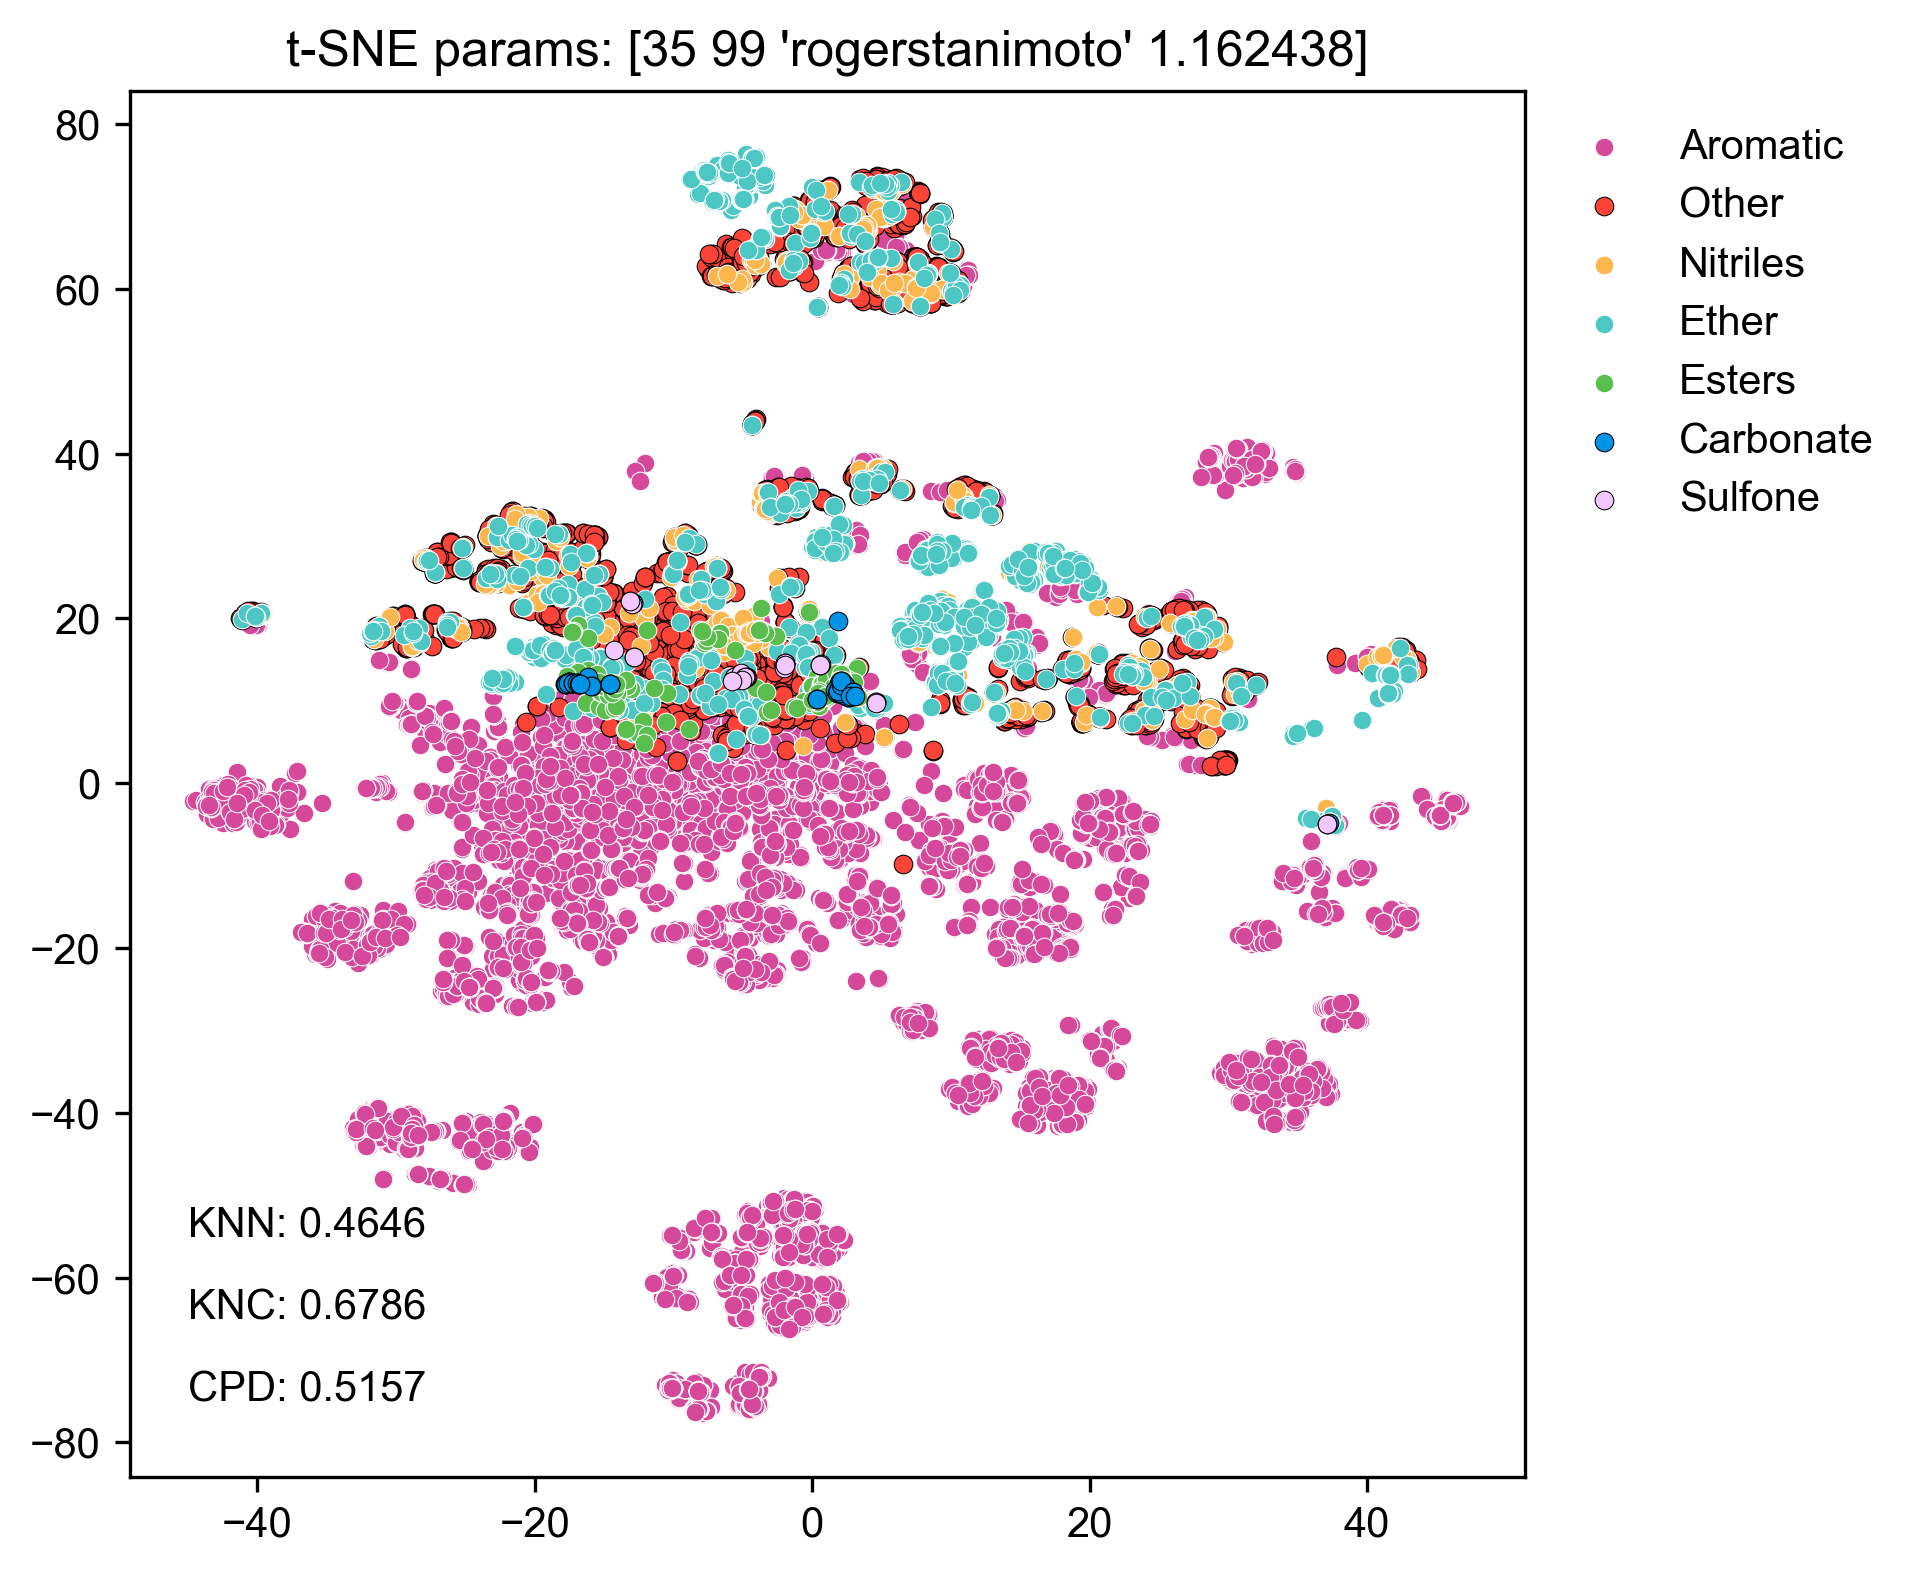

In [104]:
# plt.figure(figsize=(6, 6))
# plt.title("t-SNE params: {}".format(df_wasser_tsne_open[['random_state', 'perplexity', 'metric', 'exaggeration']].iloc[2].values))
# sns.scatterplot(
#     x="tnse_0", y="tnse_1",
#     hue="class",
#     palette=sns.color_palette("rainbow", 7),
#     data=df,
#     legend="full",
#     alpha=0.85
# )
trial = 2
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df['tnse_0'] = X_tsne[:,0]
df['tnse_1'] = X_tsne[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("t-SNE params: {}".format(df_wasser_tsne_open[['random_state', 'perplexity', 'metric', 'exaggeration']].iloc[trial].values))
classes = ['Aromatic', 'Other', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
# colors = [(0, 0.576, 0.902), (0.298, 0.78, 0.77), (0.984, 0.713, 0.305), (0.349,0.745,0.306), (0.95, 0.78, 0.996), (0.984, 0.262, 0.219), (0.557, 0, 0.998)]
colors = [(0.839, 0.286, 0.604), (0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]
# colors.reverse()
# edge_color = ['black', 'white', 'gray', 'white', 'black', 'gray', 'white']
edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df.loc[df['class'] == cls]
    ax.scatter(df_cls['tnse_0'], df_cls['tnse_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=20)
    i += 1
plt.text(-45, -55, 'KNN: {:.4f}'.format(df_wasser_tsne_open['knn'][trial]), family='Arial', size=10, color='black')
plt.text(-45, -65, 'KNC: {:.4f}'.format(df_wasser_tsne_open['knc'][trial]), family='Arial', size=10, color='black')
plt.text(-45, -75, 'CPD: {:.4f}'.format(df_wasser_tsne_open['cpd'][trial]), family='Arial', size=10, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('tsne_trial_{}_open.eps'.format(trial), dpi=300, bbox_inches='tight')

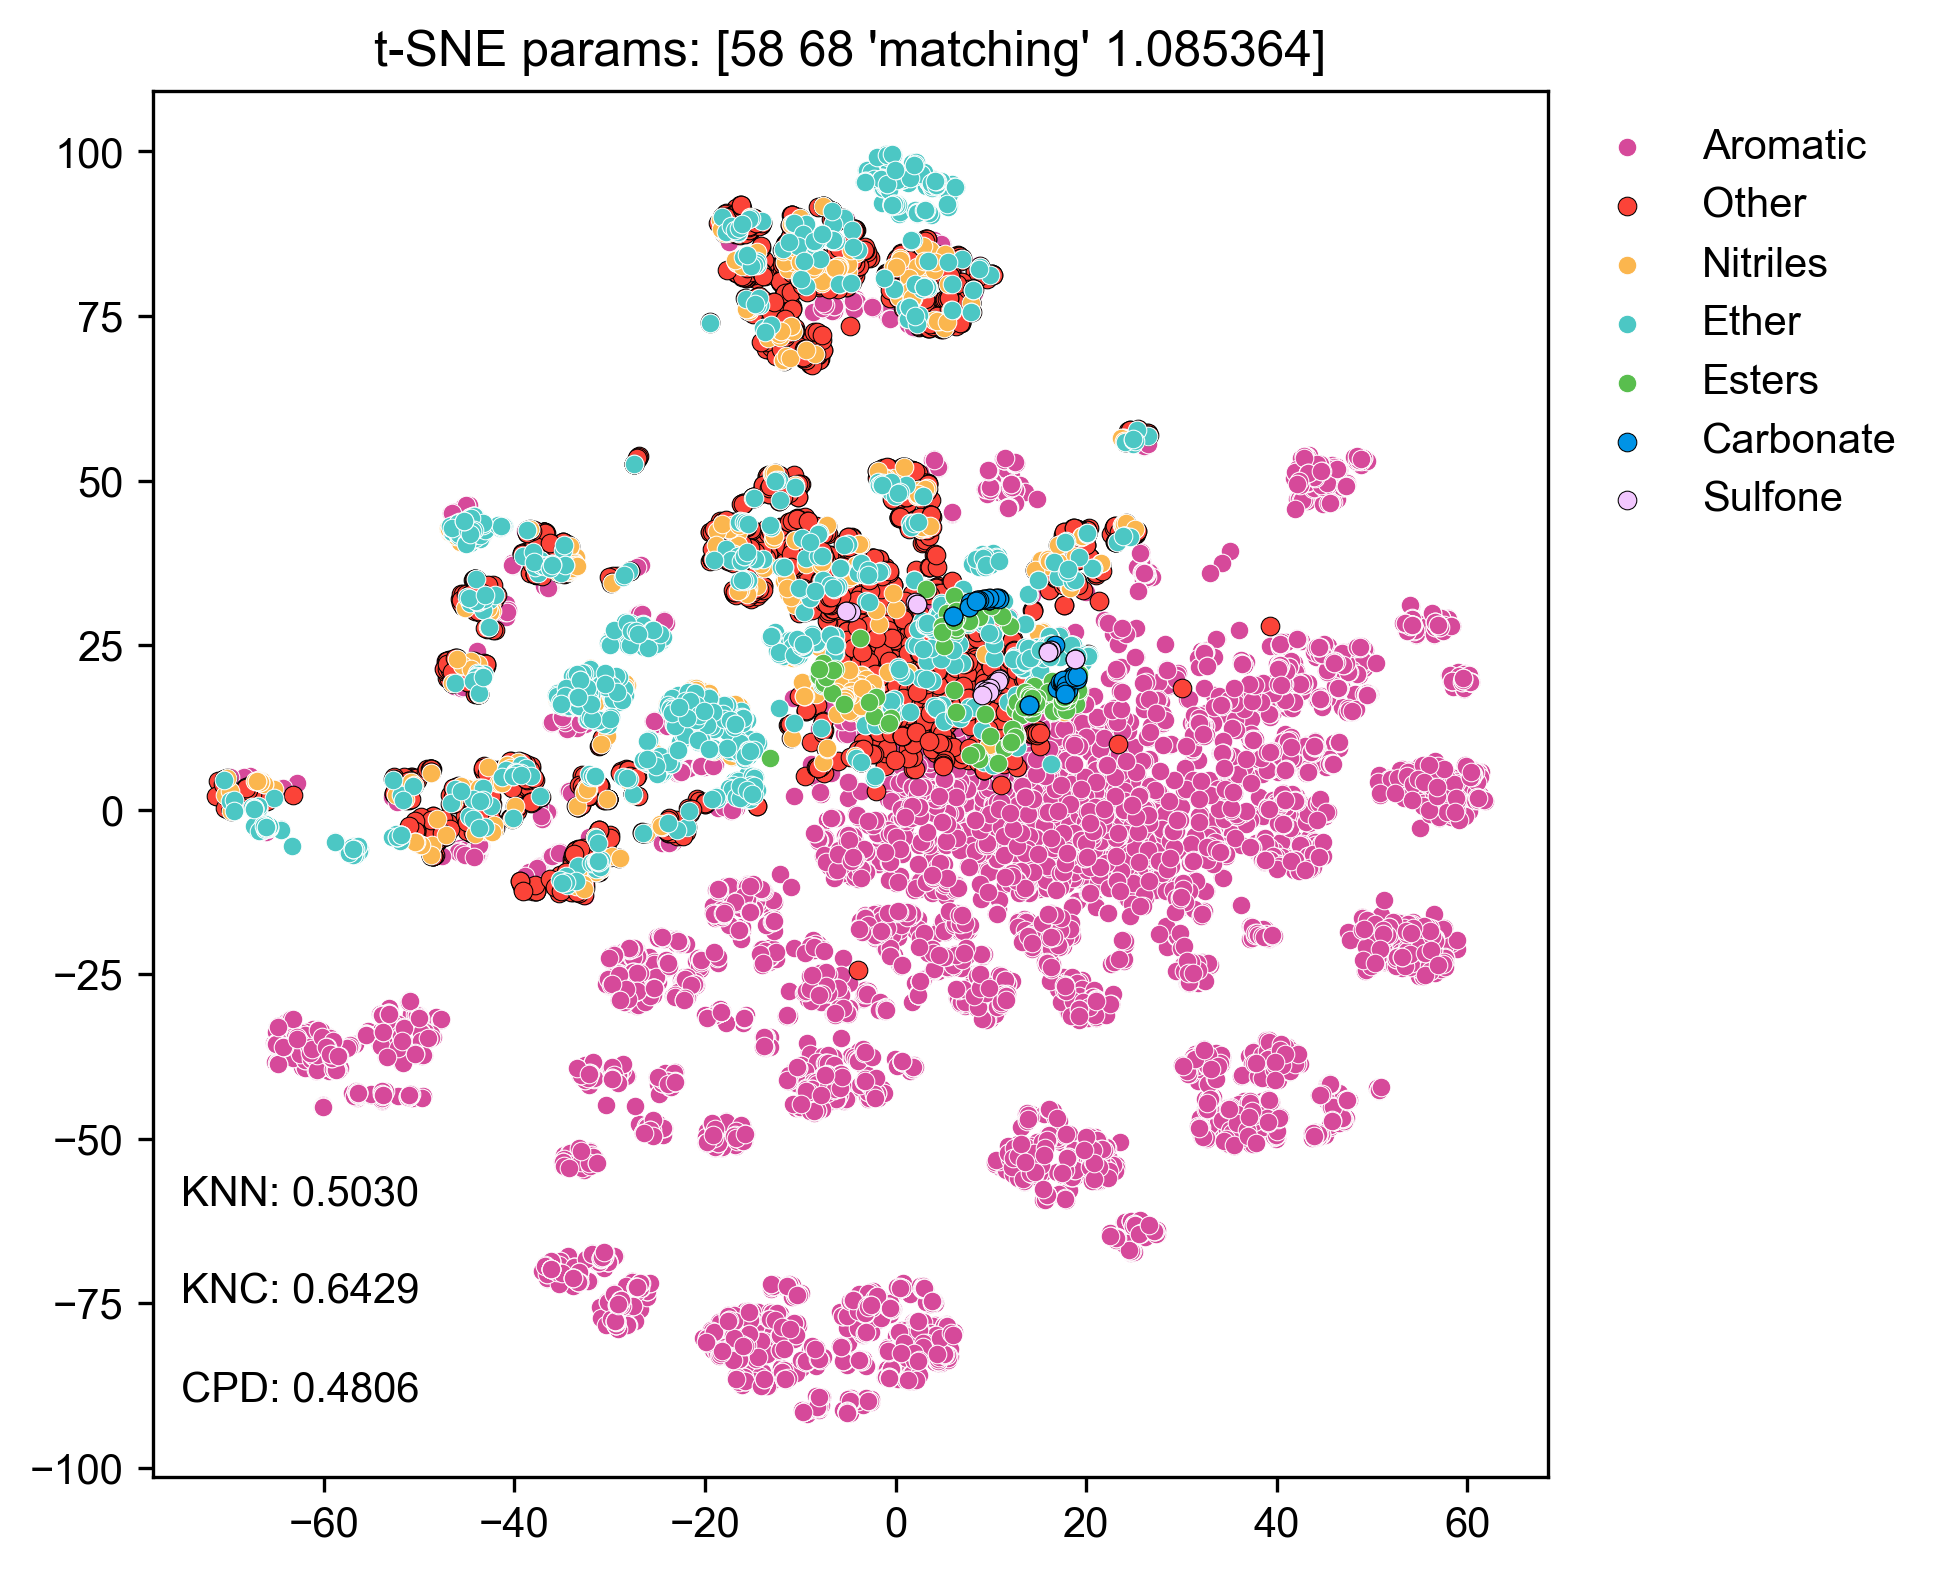

In [105]:
# plt.figure(figsize=(6, 6))
# sns.scatterplot(
#     x="tnse_0", y="tnse_1",
#     hue="class",
#     palette=sns.color_palette("rainbow", 7),
#     data=df,
#     legend="full",
#     alpha=0.85
# )
trial = 4
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df['tnse_0'] = X_tsne[:,0]
df['tnse_1'] = X_tsne[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("t-SNE params: {}".format(df_wasser_tsne_open[['random_state', 'perplexity', 'metric', 'exaggeration']].iloc[trial].values))
classes = ['Aromatic', 'Other', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
# colors = [(0, 0.576, 0.902), (0.298, 0.78, 0.77), (0.984, 0.713, 0.305), (0.349,0.745,0.306), (0.95, 0.78, 0.996), (0.984, 0.262, 0.219), (0.557, 0, 0.998)]
colors = [(0.839, 0.286, 0.604), (0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]
# colors.reverse()
# edge_color = ['black', 'white', 'gray', 'white', 'black', 'gray', 'white']
edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df.loc[df['class'] == cls]
    ax.scatter(df_cls['tnse_0'], df_cls['tnse_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=20)
    i += 1
plt.text(-75, -60, 'KNN: {:.4f}'.format(df_wasser_tsne_open['knn'][trial]), family='Arial', size=10, color='black')
plt.text(-75, -75, 'KNC: {:.4f}'.format(df_wasser_tsne_open['knc'][trial]), family='Arial', size=10, color='black')
plt.text(-75, -90, 'CPD: {:.4f}'.format(df_wasser_tsne_open['cpd'][trial]), family='Arial', size=10, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('tsne_trial_{}_open.eps'.format(trial), dpi=300, bbox_inches='tight')

In [ ]:
## do not use this
# ## plot bar plots of the wasserstein distances for two iterations of t-SNE
# for i in range(len(cols)):
#     for j in range(i+1,len(cols)):
#         col_1 = cols[i]
#         col_2 = cols[j]
#         plt.figure(figsize=(6, 6))
#         # plt.title('Wasserstein distance between {} and {}'.format(col_1, col_2))
#         # plt.hist(df_wasser_tsne_open[col_1+'_'+col_2], bins=20, color='gray')
#         plt.bar(df_wasser_tsne_open[col_1+'_'+col_2].iloc[indices_tsne_open_tsne], 1, color='red')
#         plt.xlabel('Wasserstein distance')
#         plt.ylabel('Wasserstein distance')
#         # plt.savefig('wasser_tsne_open_{}_{}.eps'.format(col_1, col_2), dpi=300, bbox_inches='tight')

In [139]:
## not using this plot!!!
keys = list(df_wasser_tsne_open.columns[8:])
# # avg_values = [sum(values) / len(values) for values in dict_tsne_bo_.values()]

# # # values = list(dict_tsne_bo_.values())
# values_1 = [values[0] for values in df_wasser_tsne_open[keys][2].values()]
values_1 = df_wasser_tsne_open[keys].iloc[2].values
values_2 = df_wasser_tsne_open[keys].iloc[4].values

# # # Creating a bar plot
plt.figure(figsize=(6, 6))
plt.bar(keys, values_2, color=orange, label='Iteration: 4', linewidth=1, edgecolor='black')
plt.bar(keys, values_1, color=blue, label='Iteration: 2')
# plt.bar(keys, values_3, color='blue', label='Perplexity: 50')
plt.xticks(rotation=90)
# plt.xlabel('Parameters')
plt.ylabel('Wasserstein Distance')
# plt.title('Average Values of Parameters in the Dataset')
plt.legend(frameon=False)
plt.show
# values_1
# df_wasser_tsne_open[keys].iloc[2].values
# plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
# plt.savefig('wasser_dist_tsne_trial.eps', dpi=300, bbox_inches='tight')

<function matplotlib.pyplot.show(close=None, block=None)>

**Save tSNE as HTML files (tSNE using openTSNE)**

smiles  mean_property_value   database      class  \
0        C(C#CC(C)C)(C)C             5.481535  MP_oxstab      Other   
1                C(=O)=O             9.433272  MP_oxstab      Other   
2                      O             7.902121  MP_oxstab      Other   
3          C(=C\C)/C(C)C             5.085723  MP_oxstab      Other   
4      c1(c(ccc(c1)C)C)C             4.733493  MP_oxstab   Aromatic   
...                  ...                  ...        ...        ...   
18383       O=C1OCC(F)O1             0.977029      EDB_2  Carbonate   
18384          O=C1OCCO1             0.909369      EDB_2  Carbonate   
18385              O=C=O             0.999000      EDB_2      Other   
18386      O=S1(=O)CCCC1             0.985000      EDB_2    Sulfone   
18387          O=c1occo1             0.968000      EDB_2   Aromatic   

          TSNE_0     TSNE_1                                           solv  
0       5.317726  19.608474  <rdkit.Chem.rdchem.Mol object at 0x1508fdf20>  
1       2.272262  17.790176  <rdkit.Chem.rdchem.Mol object at 0x150f98200>  
2       2.631746  18.703068  <rdkit.Chem.rdchem.Mol object at 0x150f98120>  
3       5.377594  18.744755  <rdkit.Chem.rdchem.Mol object at 0x150f98040>  
4      10.869368   0.089336  <rdkit.Chem.rdchem.Mol object at 0x150f980b0>  
...          ...        ...                                            ...  
18383   8.495762  31.727039  <rdkit.Chem.rdchem.Mol object at 0x155028430>  
18384   5.988254  29.368194  <rdkit.Chem.rdchem.Mol object at 0x1550284a0>  
18385   2.276040  17.803165  <rdkit.Chem.rdchem.Mol object at 0x155028510>  
18386   2.216475  31.213334  <rdkit.Chem.rdchem.Mol object at 0x155028580>  
18387  11.298578  10.610191  <rdkit.Chem.rdchem.Mol object at 0x1550285f0>  

[18388 rows x 7 columns]
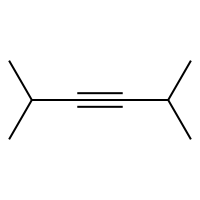
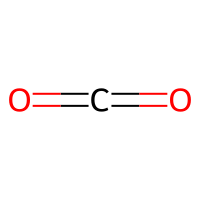
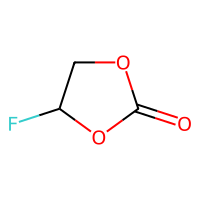
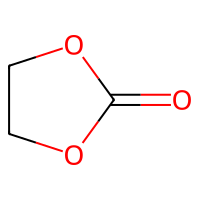
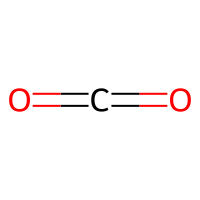
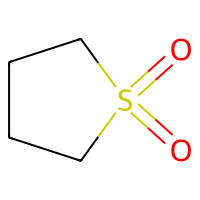

In [105]:
trial = 4
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df['TSNE_0'] = X_tsne[:,0]
df['TSNE_1'] = X_tsne[:,1]
df

In [37]:
df['class'].value_counts()

class
Aromatic     11260
Other         4243
Ether         1934
Nitriles       715
Esters         143
Carbonate       64
Sulfone         29
Name: count, dtype: int64

In [106]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df,'smiles', 'solv')

svgs_solv = [moltosvg(m).data for m in df.solv]
smile = df['smiles'].values.tolist()
database_class = df['class'].values.tolist()
database = df['database'].values.tolist()
ind = df.index.values.tolist()
ChangeMoleculeRendering(renderer='PNG')

## provided by copilot
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

color_dict = {'Aromatic':(0.839, 0.286, 0.604), 'Other':(0.984, 0.262, 0.219), 'Ether':(0.298, 0.78, 0.77),
              'Nitriles':(0.984, 0.713, 0.305), 'Esters':(0.349,0.745,0.306), 'Carbonate':(0, 0.576, 0.902), 
              'Sulfone':(0.95, 0.78, 0.996)}

color_dict_hex = {k: rgb_to_hex(v) for k, v in color_dict.items()}

# source = ColumnDataSource(data=dict(x=df['TSNE_0'], y=df['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, color=df['class'].map(color_dict_hex)))
source = ColumnDataSource(data=dict(x=df['TSNE_0'], y=df['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, database=database, color=df['class'].map(color_dict_hex)))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Database: @database </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Molecular visualizations of solvent molecules (Figure 1(d))"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        legend_field='desc',
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_tsne_openTSNE_trial_{}.html".format(trial))
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/red-dim-visualization/fig1-data/interactive_map_tsne_openTSNE_trial_4.html'

**Check which trial is better for tSNE (openTSNE)**

In [81]:
dme = Chem.MolToSmiles(Chem.MolFromSmiles('COCCOC'))
dg = Chem.MolToSmiles(Chem.MolFromSmiles('COCCOCCOC'))
tg = Chem.MolToSmiles(Chem.MolFromSmiles('COCCOCCOCCOC'))
dmc = Chem.MolToSmiles(Chem.MolFromSmiles('COC(=O)OC'))
emc = Chem.MolToSmiles(Chem.MolFromSmiles('CCOC(=O)OC'))
ec = Chem.MolToSmiles(Chem.MolFromSmiles('C1COC(=O)O1'))
ref_mol_sm = [dme, dg, tg, dmc, emc, ec]
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref_mol_sm]
ref_name = ['dme', 'dg', 'tg', 'dmc', 'emc', 'ec']

In [82]:
dme_ind = df.loc[df['smiles'] == dme].index[0]
dg_ind = df.loc[df['smiles'] == dg].index[0]
tg_ind = df.loc[df['smiles'] == tg].index[0]
dmc_ind = df.loc[df['smiles'] == dmc].index[0]
emc_ind = df.loc[df['smiles'] == emc].index[0]
ec_ind = df.loc[df['smiles'] == ec].index[0]
ref_mol_ind = [dme_ind, dg_ind, tg_ind, dmc_ind, emc_ind, ec_ind]

In [100]:
X_tsne = np.load('./X_tsne_trial_2_openTSNE.npy', allow_pickle=True)
# X_tsne = np.load('./X_tsne_trial_4_openTSNE.npy', allow_pickle=True)
dme_tsne = X_tsne[dme_ind]
dg_tsne = X_tsne[dg_ind]
tg_tsne = X_tsne[tg_ind]
dmc_tsne = X_tsne[dmc_ind]
emc_tsne = X_tsne[emc_ind]
ec_tsne = X_tsne[ec_ind]

In [99]:
## for trial-4
print(dg_tsne)
print(dmc_tsne)

[16.33715016 25.21469508]
[14.03739703 15.89202048]


In [101]:
## for trial-2
print(dg_tsne)
print(dmc_tsne)

[37.35106191 -4.68487206]
[ 0.34438116 10.21441577]


In [163]:
## euclidean distances between the points for iteration 2
print(distance.euclidean(dg_tsne, tg_tsne))
print(distance.euclidean(dg_tsne, dmc_tsne))
print(distance.euclidean(dg_tsne, ec_tsne))
print(distance.euclidean(tg_tsne, dmc_tsne))
print(distance.euclidean(tg_tsne, ec_tsne))
print(distance.euclidean(dmc_tsne, ec_tsne))
print(distance.euclidean(dmc_tsne, emc_tsne))
print(distance.euclidean(emc_tsne, ec_tsne))

0.0035534855601563956
39.893397925019976
54.51901479062404
39.88999139369598
54.51554436472513
15.005448089380188
2.4736301746991702
16.674956562433692


In [165]:
## euclidean distances between the points for iteration 4
print(distance.euclidean(dg_tsne, tg_tsne))
print(distance.euclidean(dg_tsne, dmc_tsne))
print(distance.euclidean(dg_tsne, ec_tsne))
print(distance.euclidean(tg_tsne, dmc_tsne))
print(distance.euclidean(tg_tsne, ec_tsne))
print(distance.euclidean(dmc_tsne, ec_tsne))
print(distance.euclidean(dmc_tsne, emc_tsne))
print(distance.euclidean(emc_tsne, ec_tsne))

0.002888010007651806
9.602141747326785
11.150113123688651
9.60467590676574
11.148388756360099
15.695065503335764
4.331600664531009
16.39171051915507


In [84]:
def check_similarity(mol1, mol2):
    # mol = Chem.MolFromSmiles(smiles)
    mol_1_fps = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    mol_2_fps = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    similarity = DataStructs.FingerprintSimilarity(mol_1_fps, mol_2_fps)
    return similarity

In [90]:
dict_euclid_dist_tsne_open = {'trial': [], 'eucl_dme_dg':[], 'eucl_dme_tg':[], 'eucl_dme_dmc':[], 'eucl_dme_emc':[], 'eucl_dme_ec':[], 'eucl_dg_tg':[], 'eucl_dg_dmc':[], 'eucl_dg_emc':[], 'eucl_dg_ec':[], 'eucl_tg_dmc':[], 'eucl_tg_emc':[], 'eucl_tg_ec':[], 'eucl_dmc_emc':[], 'eucl_dmc_ec':[], 'eucl_emc_ec':[],
                              'jacc_dme_dg':[], 'jacc_dme_tg':[], 'jacc_dme_dmc':[], 'jacc_dme_emc':[], 'jacc_dme_ec':[], 'jacc_dg_tg':[], 'jacc_dg_dmc':[], 'jacc_dg_emc':[], 'jacc_dg_ec':[], 'jacc_tg_dmc':[], 'jacc_tg_emc':[], 'jacc_tg_ec':[], 'jacc_dmc_emc':[], 'jacc_dmc_ec':[], 'jacc_emc_ec':[],
                              'sim_dme_dg':[], 'sim_dme_tg':[], 'sim_dme_dmc':[], 'sim_dme_emc':[], 'sim_dme_ec':[], 'sim_dg_tg':[], 'sim_dg_dmc':[], 'sim_dg_emc':[], 'sim_dg_ec':[], 'sim_tg_dmc':[], 'sim_tg_emc':[], 'sim_tg_ec':[], 'sim_dmc_emc':[], 'sim_dmc_ec':[], 'sim_emc_ec':[]}
dict_euclid_dist_tsne_open

{'trial': [],
 'eucl_dme_dg': [],
 'eucl_dme_tg': [],
 'eucl_dme_dmc': [],
 'eucl_dme_emc': [],
 'eucl_dme_ec': [],
 'eucl_dg_tg': [],
 'eucl_dg_dmc': [],
 'eucl_dg_emc': [],
 'eucl_dg_ec': [],
 'eucl_tg_dmc': [],
 'eucl_tg_emc': [],
 'eucl_tg_ec': [],
 'eucl_dmc_emc': [],
 'eucl_dmc_ec': [],
 'eucl_emc_ec': [],
 'jacc_dme_dg': [],
 'jacc_dme_tg': [],
 'jacc_dme_dmc': [],
 'jacc_dme_emc': [],
 'jacc_dme_ec': [],
 'jacc_dg_tg': [],
 'jacc_dg_dmc': [],
 'jacc_dg_emc': [],
 'jacc_dg_ec': [],
 'jacc_tg_dmc': [],
 'jacc_tg_emc': [],
 'jacc_tg_ec': [],
 'jacc_dmc_emc': [],
 'jacc_dmc_ec': [],
 'jacc_emc_ec': [],
 'sim_dme_dg': [],
 'sim_dme_tg': [],
 'sim_dme_dmc': [],
 'sim_dme_emc': [],
 'sim_dme_ec': [],
 'sim_dg_tg': [],
 'sim_dg_dmc': [],
 'sim_dg_emc': [],
 'sim_dg_ec': [],
 'sim_tg_dmc': [],
 'sim_tg_emc': [],
 'sim_tg_ec': [],
 'sim_dmc_emc': [],
 'sim_dmc_ec': [],
 'sim_emc_ec': []}

In [92]:
dict_euclid_dist_tsne_open['trial'].append(4) ## remember to change this
for i in range(len(ref_mol)):
    for j in range(i+1, len(ref_mol)):
        dict_euclid_dist_tsne_open['eucl_'+ref_name[i]+'_'+ref_name[j]].append(distance.euclidean(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]]))
        dict_euclid_dist_tsne_open['jacc_'+ref_name[i]+'_'+ref_name[j]].append(distance.jaccard(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]]))
        # dict_euclid_dist_tsne_open['jacc_'+ref_name[i]+'_'+ref_name[j]].append(1-distance.jaccard_similarity_score(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]]))
        dict_euclid_dist_tsne_open['sim_'+ref_name[i]+'_'+ref_name[j]].append(check_similarity(ref_mol[i], ref_mol[j]))
        # print("TC for {}-{}".format(ref_name[i], ref_name[j]), check_similarity(ref_mol[i], ref_mol[j]))
        # print("Euclidean distance for {}-{}".format(ref_name[i], ref_name[j]),distance.euclidean(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]]))

In [93]:
X_tsne = df_tsne_default_open[['tsne_0', 'tsne_1']].values
X_tsne = df_tsne_default_open[['tsne_0', 'tsne_1']].values
dme_tsne = X_tsne[dme_ind]
dg_tsne = X_tsne[dg_ind]
tg_tsne = X_tsne[tg_ind]
dmc_tsne = X_tsne[dmc_ind]
emc_tsne = X_tsne[emc_ind]
ec_tsne = X_tsne[ec_ind]

dict_euclid_dist_tsne_open['trial'].append('default') ## remember to change this
for i in range(len(ref_mol)):
    for j in range(i+1, len(ref_mol)):
        dict_euclid_dist_tsne_open['eucl_'+ref_name[i]+'_'+ref_name[j]].append(distance.euclidean(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]])) ## euclidean distance
        dict_euclid_dist_tsne_open['jacc_'+ref_name[i]+'_'+ref_name[j]].append(distance.jaccard(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]])) ## jaccard distance -> not a useful metric according to copilot
        dict_euclid_dist_tsne_open['sim_'+ref_name[i]+'_'+ref_name[j]].append(check_similarity(ref_mol[i], ref_mol[j]))
        # print("TC for {}-{}".format(ref_name[i], ref_name[j]), check_similarity(ref_mol[i], ref_mol[j]))
        # print("Euclidean distance for {}-{}".format(ref_name[i], ref_name[j]),distance.euclidean(X_tsne[ref_mol_ind[i]], X_tsne[ref_mol_ind[j]]))

In [94]:
dict_euclid_dist_tsne_open

{'trial': [2, 4, 'default'],
 'eucl_dme_dg': [0.9223135542674644, 0.9223135542674644, 0.9223135542674644],
 'eucl_dme_tg': [0.9098258799010537, 0.9098258799010537, 0.9098258799010537],
 'eucl_dme_dmc': [40.01574171990644, 40.01574171990644, 40.01574171990644],
 'eucl_dme_emc': [32.31111599009248, 32.31111599009248, 32.31111599009248],
 'eucl_dme_ec': [69.02691361007108, 69.02691361007108, 69.02691361007108],
 'eucl_dg_tg': [0.01436778051335948, 0.01436778051335948, 0.01436778051335948],
 'eucl_dg_dmc': [40.93387810193613, 40.93387810193613, 40.93387810193613],
 'eucl_dg_emc': [33.233402708112784, 33.233402708112784, 33.233402708112784],
 'eucl_dg_ec': [69.93915766456817, 69.93915766456817, 69.93915766456817],
 'eucl_tg_dmc': [40.92208263368293, 40.92208263368293, 40.92208263368293],
 'eucl_tg_emc': [33.22094186981029, 33.22094186981029, 33.22094186981029],
 'eucl_tg_ec': [69.92574445195844, 69.92574445195844, 69.92574445195844],
 'eucl_dmc_emc': [8.33640541012951, 8.33640541012951, 8.3

In [199]:
df_euclid_dist_tsne_open = pd.DataFrame(dict_euclid_dist_tsne_open)
df_euclid_dist_tsne_open.to_csv('df_euclid_dist_tc_tsne_open.csv', index=False)
df_euclid_dist_tsne_open

trial  dist_dme_dg  dist_dme_tg  dist_dme_dmc  dist_dme_emc  dist_dme_ec  \
0        2    41.827038    41.823730      3.985023      3.074101    14.743761   
1        4     0.535199     0.536429      9.176155      7.112199    10.906768   
2  default     0.922314     0.909826     40.015742     32.311116    69.026914   

   dist_dg_tg  dist_dg_dmc  dist_dg_emc  dist_dg_ec  ...  sim_dg_tg  \
0    0.003553    39.893398    38.956422   54.519015  ...        1.0   
1    0.002888     9.602142     7.350113   11.150113  ...        1.0   
2    0.014368    40.933878    33.233403   69.939158  ...        1.0   

   sim_dg_dmc  sim_dg_emc  sim_dg_ec  sim_tg_dmc  sim_tg_emc  sim_tg_ec  \
0    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
1    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
2    0.166667    0.173913        0.0    0.166667    0.173913        0.0   

   sim_dmc_emc  sim_dmc_ec  sim_emc_ec  
0     0.529412        0.05    0.038462  
1     0.529412        0.05    0.038462  
2     0.529412        0.05    0.038462  

[3 rows x 31 columns]

In [ ]:
df_euclid_dist_tsne_open = pd.DataFrame(dict_euclid_dist_tsne_open)
# df_euclid_dist_tsne_open.to_csv('df_euclid_dist_tsne_open.csv', index=False)
df_euclid_dist_tsne_open

**Check which trial is better for UMAP**

In [162]:
X_umap = np.load('./X_umap_trial_49.npy', allow_pickle=True)
dme_umap = X_umap[dme_ind]
dg_umap = X_umap[dg_ind]
tg_umap = X_umap[tg_ind]
dmc_umap = X_umap[dmc_ind]
emc_umap = X_umap[emc_ind]
ec_umap = X_umap[ec_ind]

In [145]:
## run only once
dict_euclid_dist_umap = {'trial': [], 'eucl_dme_dg':[], 'eucl_dme_tg':[], 'eucl_dme_dmc':[], 'eucl_dme_emc':[], 'eucl_dme_ec':[], 'eucl_dg_tg':[], 'eucl_dg_dmc':[], 'eucl_dg_emc':[], 'eucl_dg_ec':[], 'eucl_tg_dmc':[], 'eucl_tg_emc':[], 'eucl_tg_ec':[], 'eucl_dmc_emc':[], 'eucl_dmc_ec':[], 'eucl_emc_ec':[],
                         'jacc_dme_dg':[], 'jacc_dme_tg':[], 'jacc_dme_dmc':[], 'jacc_dme_emc':[], 'jacc_dme_ec':[], 'jacc_dg_tg':[], 'jacc_dg_dmc':[], 'jacc_dg_emc':[], 'jacc_dg_ec':[], 'jacc_tg_dmc':[], 'jacc_tg_emc':[], 'jacc_tg_ec':[], 'jacc_dmc_emc':[], 'jacc_dmc_ec':[], 'jacc_emc_ec':[],
                         'sim_dme_dg':[], 'sim_dme_tg':[], 'sim_dme_dmc':[], 'sim_dme_emc':[], 'sim_dme_ec':[], 'sim_dg_tg':[], 'sim_dg_dmc':[], 'sim_dg_emc':[], 'sim_dg_ec':[], 'sim_tg_dmc':[], 'sim_tg_emc':[], 'sim_tg_ec':[], 'sim_dmc_emc':[], 'sim_dmc_ec':[], 'sim_emc_ec':[]} ## remember to change this

In [163]:
dict_euclid_dist_umap['trial'].append(49) ## remember to change this
for i in range(len(ref_mol)):
    for j in range(i+1, len(ref_mol)):
        dict_euclid_dist_umap['eucl_'+ref_name[i]+'_'+ref_name[j]].append(distance.euclidean(X_umap[ref_mol_ind[i]], X_umap[ref_mol_ind[j]]))
        dict_euclid_dist_umap['jacc_'+ref_name[i]+'_'+ref_name[j]].append(distance.jaccard(X_umap[ref_mol_ind[i]], X_umap[ref_mol_ind[j]]))
        dict_euclid_dist_umap['sim_'+ref_name[i]+'_'+ref_name[j]].append(check_similarity(ref_mol[i], ref_mol[j]))
        # print("TC for {}-{}".format(ref_name[i], ref_name[j]), check_similarity(ref_mol[i], ref_mol[j]))
        # print("Euclidean distance for {}-{}".format(ref_name[i], ref_name[j]),distance.euclidean(X_umap[ref_mol_ind[i]], X_umap[ref_mol_ind[j]]))

In [164]:
dict_euclid_dist_umap

{'trial': [18, 20, 20, 34, 46, 48, 49],
 'eucl_dme_dg': [5.7362165451049805,
  0.09828903526067734,
  0.15655994415283203,
  4.358741760253906,
  6.601867198944092,
  0.05985858291387558,
  3.0997657775878906],
 'eucl_dme_tg': [5.863338947296143,
  0.05574124678969383,
  0.11565089970827103,
  4.478253364562988,
  6.627893924713135,
  0.06296589970588684,
  3.093909502029419],
 'eucl_dme_dmc': [0.09166131913661957,
  0.9364763498306274,
  5.936793804168701,
  0.4713784158229828,
  0.22240890562534332,
  1.320259690284729,
  1.297391653060913],
 'eucl_dme_emc': [0.4688473641872406,
  1.0392647981643677,
  5.921510696411133,
  1.0651146173477173,
  0.4341825246810913,
  1.260584831237793,
  1.509385585784912],
 'eucl_dme_ec': [2.3051505088806152,
  2.6189942359924316,
  6.660544395446777,
  3.6702828407287598,
  2.2369296550750732,
  3.1777679920196533,
  1.2034493684768677],
 'eucl_dg_tg': [0.13131827116012573,
  0.04257908836007118,
  0.040959786623716354,
  0.12266016751527786,
  0.06

In [165]:
df_euclid_dist_umap = pd.DataFrame(dict_euclid_dist_umap)
df_euclid_dist_umap.to_csv('df_euclid_dist_tc_umap.csv', index=False)
df_euclid_dist_umap

trial  eucl_dme_dg  eucl_dme_tg  eucl_dme_dmc  eucl_dme_emc  eucl_dme_ec  \
0     18     5.736217     5.863339      0.091661      0.468847     2.305151   
1     20     0.098289     0.055741      0.936476      1.039265     2.618994   
2     20     0.156560     0.115651      5.936794      5.921511     6.660544   
3     34     4.358742     4.478253      0.471378      1.065115     3.670283   
4     46     6.601867     6.627894      0.222409      0.434183     2.236930   
5     48     0.059859     0.062966      1.320260      1.260585     3.177768   
6     49     3.099766     3.093910      1.297392      1.509386     1.203449   

   eucl_dg_tg  eucl_dg_dmc  eucl_dg_emc  eucl_dg_ec  ...  sim_dg_tg  \
0    0.131318     5.661285     5.756502    7.692867  ...        1.0   
1    0.042579     1.021189     1.121703    2.716276  ...        1.0   
2    0.040960     6.052107     6.029833    6.799451  ...        1.0   
3    0.122660     4.803895     4.838633    7.794221  ...        1.0   
4    0.064254     6.434169     6.262108    8.554388  ...        1.0   
5    0.005291     1.262839     1.202886    3.119405  ...        1.0   
6    0.022126     3.590380     3.706754    3.996727  ...        1.0   

   sim_dg_dmc  sim_dg_emc  sim_dg_ec  sim_tg_dmc  sim_tg_emc  sim_tg_ec  \
0    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
1    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
2    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
3    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
4    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
5    0.166667    0.173913        0.0    0.166667    0.173913        0.0   
6    0.166667    0.173913        0.0    0.166667    0.173913        0.0   

   sim_dmc_emc  sim_dmc_ec  sim_emc_ec  
0     0.529412        0.05    0.038462  
1     0.529412        0.05    0.038462  
2     0.529412        0.05    0.038462  
3     0.529412        0.05    0.038462  
4     0.529412        0.05    0.038462  
5     0.529412        0.05    0.038462  
6     0.529412        0.05    0.038462  

[7 rows x 46 columns]

save UMAP plot corresponding to best trial

In [170]:
n_neighbors_raw = !grep "values:" trial_1_save_umap | awk '{printf "%3d\n", $15}'
random_state_raw = !grep "values:" trial_1_save_umap | awk '{printf "%3d\n", $17}'
min_dist_raw = !grep "values:" trial_1_save_umap | awk '{printf "%6f\n", $19}'
repulsion_strength_raw = !grep "values:" trial_1_save_umap | awk '{printf "%6f\n", $21}'
metric_raw = !grep "values:" trial_1_save_umap | awk '{printf "%s\n", $23}'
metric_raw

["'dice'}.",
 "'euclidean'}.",
 "'dice'}.",
 "'l2'}.",
 "'chebyshev'}.",
 "'manhattan'}.",
 "'chebyshev'}.",
 "'hamming'}.",
 "'euclidean'}.",
 "'rogerstanimoto'}.",
 "'matching'}.",
 "'chebyshev'}.",
 "'rogerstanimoto'}.",
 "'symmetric_kl'}.",
 "'symmetric_kl'}.",
 "'euclidean'}.",
 "'dice'}.",
 "'rogerstanimoto'}.",
 "'manhattan'}.",
 "'hamming'}.",
 "'dice'}.",
 "'manhattan'}.",
 "'jaccard'}.",
 "'matching'}.",
 "'chebyshev'}.",
 "'l2'}.",
 "'l1'}.",
 "'matching'}.",
 "'l2'}.",
 "'dice'}.",
 "'euclidean'}.",
 "'rogerstanimoto'}.",
 "'jaccard'}.",
 "'chebyshev'}.",
 "'euclidean'}.",
 "'l2'}.",
 "'dice'}.",
 "'symmetric_kl'}.",
 "'l1'}.",
 "'hamming'}.",
 "'manhattan'}.",
 "'hamming'}.",
 "'l2'}.",
 "'l2'}.",
 "'l1'}.",
 "'jaccard'}.",
 "'l1'}.",
 "'matching'}.",
 "'symmetric_kl'}.",
 "'matching'}."]

In [171]:
min(repulsion_strength_raw)

'0.115278'

In [178]:
trial = 18 ## choosing 18 & not 34
X_umap = np.load('./X_umap_trial_{}.npy'.format(trial), allow_pickle=True)
df['umap_0'] = X_umap[:,0]
df['umap_1'] = X_umap[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
# plt.title("UMAP params: {}".format(df_param_umap_default[['random_state', 'n_neighbors', 'metric', 'repulsion_strength']].iloc[trial].values))
plt.title("Hyperparameters: {} | {} | {} | {} | {}".format(random_state_raw[trial], n_neighbors_raw[trial], metric[trial], min_dist_raw[trial], repulsion_strength_raw[trial]))
classes = ['Aromatic', 'Other', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
colors = [(0.839, 0.286, 0.604), (0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]

edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df.loc[df['class'] == cls]
    ax.scatter(df_cls['umap_0'], df_cls['umap_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=20)
    i += 1
plt.text(10, -5, 'KNN: {:.4f}'.format(knn_2[trial]), family='Arial', size=10, color='black')
plt.text(10, -7, 'KNC: {:.4f}'.format(knc_2[trial]), family='Arial', size=10, color='black')
plt.text(10, -9, 'CPD: {:.4f}'.format(cpd_2[trial]), family='Arial', size=10, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('umap_trial_{}.eps'.format(trial), dpi=300, bbox_inches='tight')

save tSNE plot using default hyper as eps

In [109]:
## tSNE embeddings using default parameters (openTSNE)
df_tsne_default_open = pd.read_csv('./tsne_default_openTSNE.csv') 
df_tsne_default_open_metric = pd.read_csv('./param_tsne_default_openTSNE.csv')
df_tsne_default_open_metric

random_state  perplexity     metric learning_rate  exaggeration       knn  \
0           NaN          30  euclidean          auto           NaN  0.512198   

        knc       cpd  Carbonate_Esters  Carbonate_Ether  ...  Ether_Sulfone  \
0  0.785714  0.415599          4.094616        28.183619  ...       2.688519   

   Ether_Nitriles  Ether_Aromatic  Ether_Other  Sulfone_Nitriles  \
0        1.841476       35.921403      1.99073         31.770112   

   Sulfone_Aromatic  Sulfone_Other  Nitriles_Aromatic  Nitriles_Other  \
0         55.468057      30.435257          39.251384        2.203586   

   Aromatic_Other  
0        6.339195  

[1 rows x 29 columns]

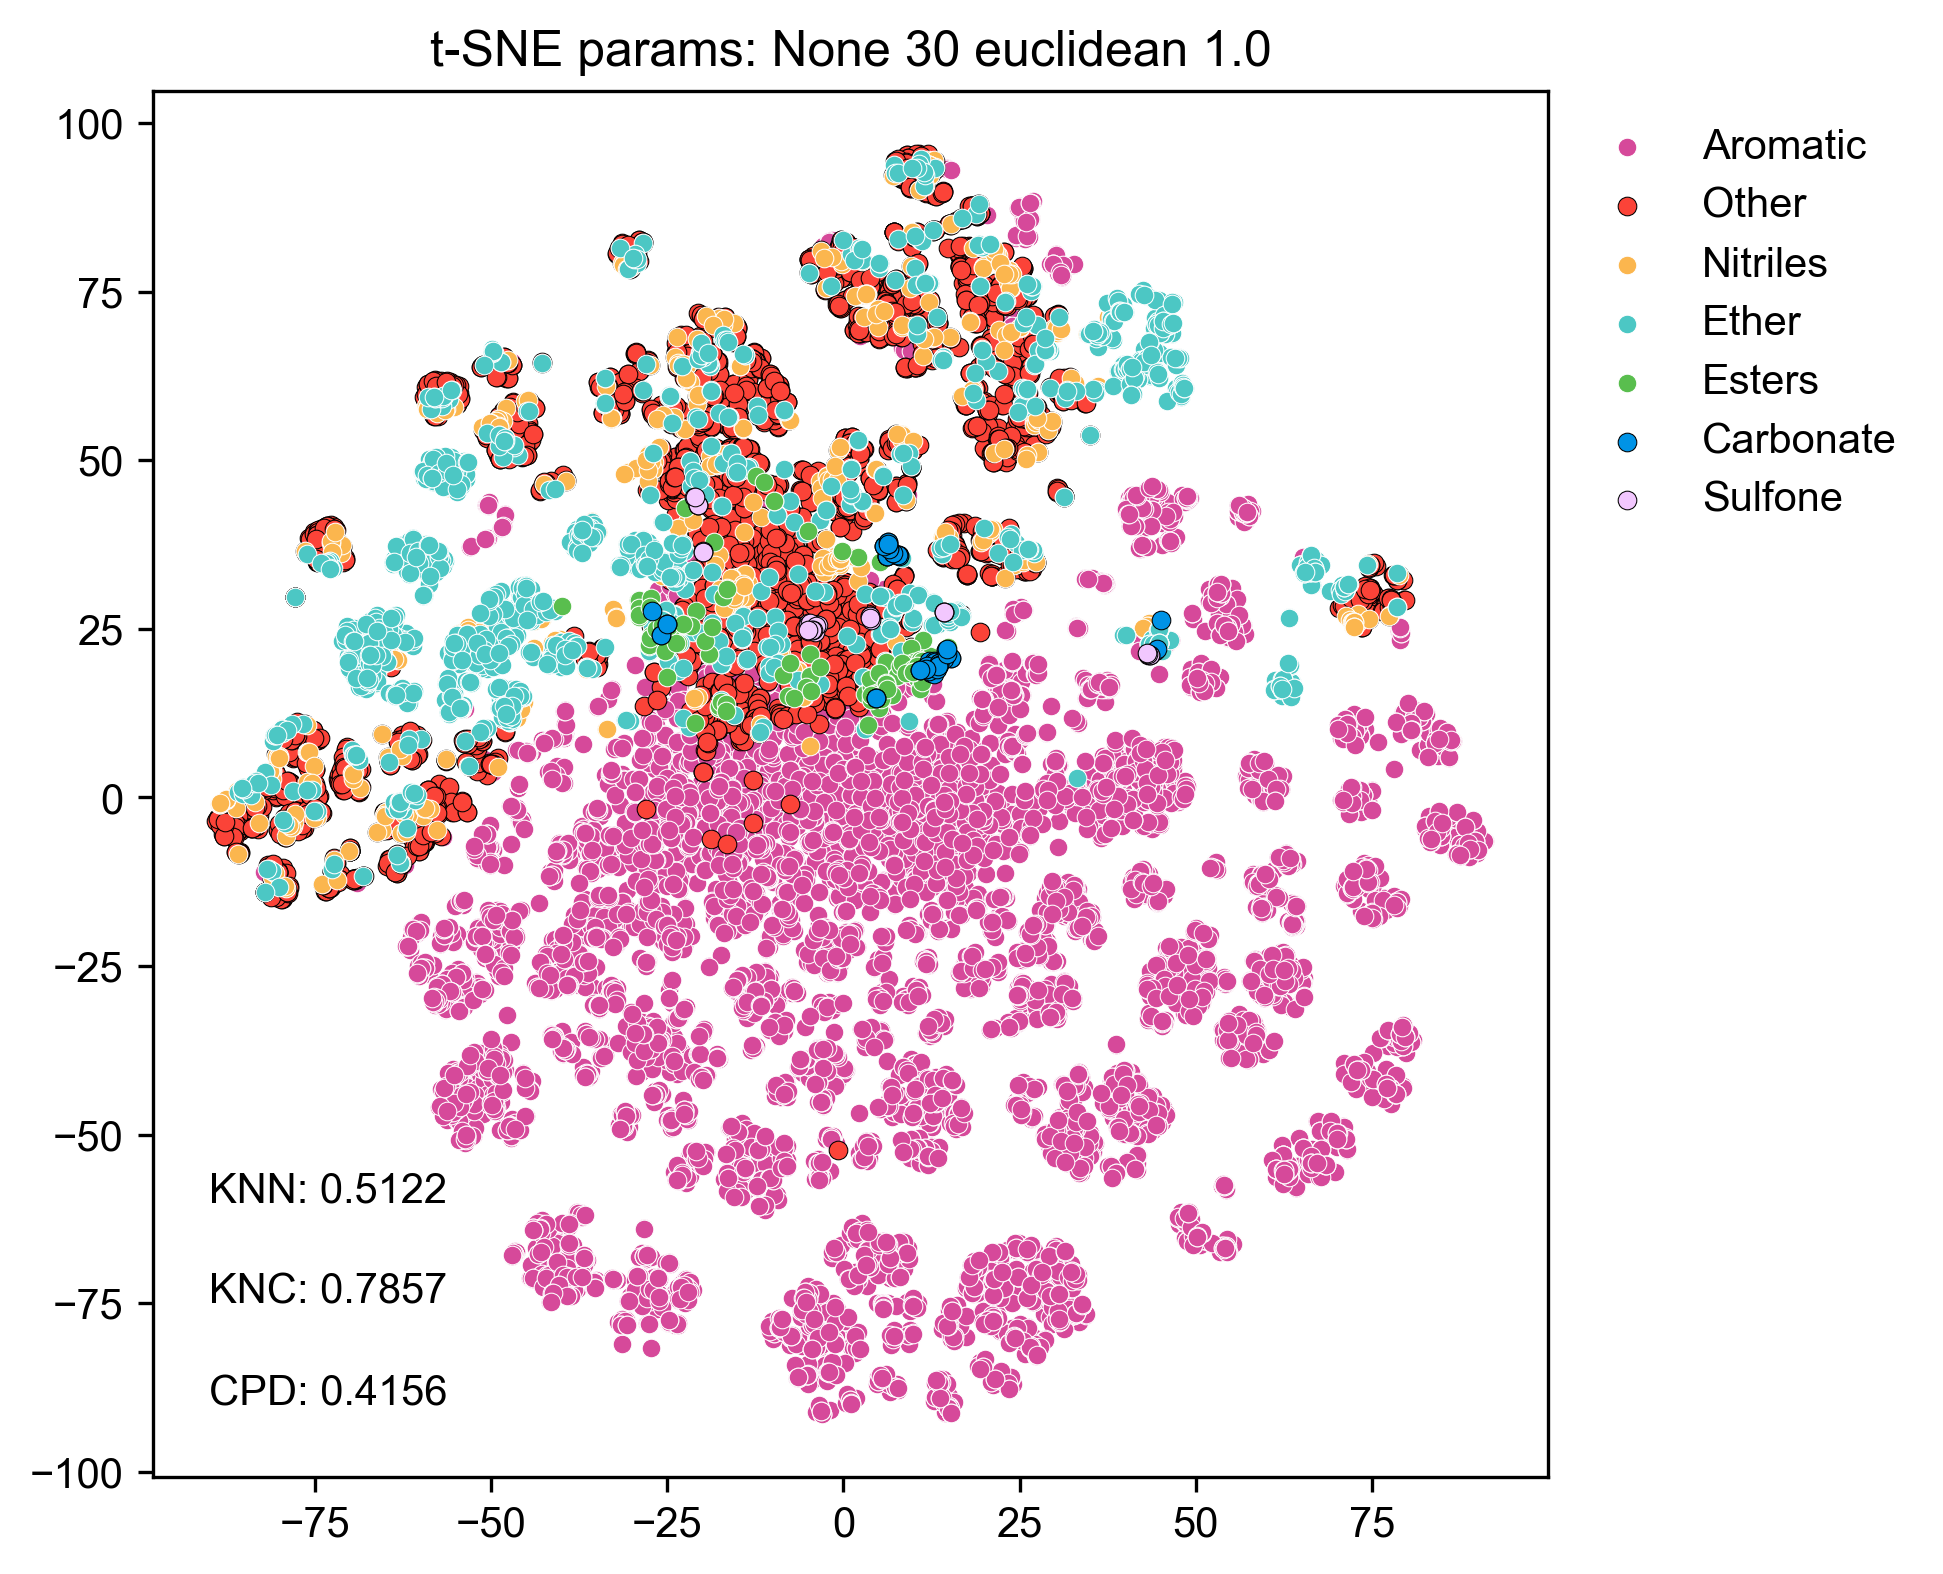

In [110]:
df_tsne_default_open = pd.read_csv('./tsne_default_openTSNE.csv') 
# df_tsne_default_open_metric = pd.read_csv('./df_metric_tsne_opentsne.csv') 
df_tsne_default_open_metric = pd.read_csv('./param_tsne_default_openTSNE.csv') 
# plt.figure(figsize=(6, 6))
# sns.scatterplot(
#     x="tsne_0", y="tsne_1",
#     hue="class",
#     palette=sns.color_palette("rainbow", 7),
#     data=df_tsne_default_open,
#     legend="full",
#     alpha=0.85
# )
# df_tsne_default_open
# trial = 4
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("t-SNE params: None 30 euclidean 1.0")
classes = ['Aromatic', 'Other', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
# colors = [(0, 0.576, 0.902), (0.298, 0.78, 0.77), (0.984, 0.713, 0.305), (0.349,0.745,0.306), (0.95, 0.78, 0.996), (0.984, 0.262, 0.219), (0.557, 0, 0.998)]
colors = [(0.839, 0.286, 0.604), (0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]
# colors.reverse()
# edge_color = ['black', 'white', 'gray', 'white', 'black', 'gray', 'white']
edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df_tsne_default_open.loc[df['class'] == cls]
    ax.scatter(df_cls['tsne_0'], df_cls['tsne_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=20)
    i += 1
plt.text(-90, -60, 'KNN: {:.4f}'.format(df_tsne_default_open_metric['knn'][0]), family='Arial', size=10, color='black')
plt.text(-90, -75, 'KNC: {:.4f}'.format(df_tsne_default_open_metric['knc'][0]), family='Arial', size=10, color='black')
plt.text(-90, -90, 'CPD: {:.4f}'.format(df_tsne_default_open_metric['cpd'][0]), family='Arial', size=10, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('tsne_trial_{}_open.eps'.format('default'), dpi=300, bbox_inches='tight')

save UMAP plot corresponding to default hyperparameters

In [111]:
df_umap_default = pd.read_csv('umap_default_m3.csv')
df_umap_default

smiles  mean_property_value   database      class    umap_0  \
0        C(C#CC(C)C)(C)C             5.481535  MP_oxstab      Other  1.751410   
1                C(=O)=O             9.433272  MP_oxstab      Other  2.335961   
2                      O             7.902121  MP_oxstab      Other  2.103016   
3          C(=C\C)/C(C)C             5.085723  MP_oxstab      Other  1.896462   
4      c1(c(ccc(c1)C)C)C             4.733493  MP_oxstab   Aromatic  1.661353   
...                  ...                  ...        ...        ...       ...   
18383       O=C1OCC(F)O1             0.977029      EDB_2  Carbonate  1.485219   
18384          O=C1OCCO1             0.909369      EDB_2  Carbonate  2.884652   
18385              O=C=O             0.999000      EDB_2      Other  2.229892   
18386      O=S1(=O)CCCC1             0.985000      EDB_2    Sulfone  2.724548   
18387          O=c1occo1             0.968000      EDB_2   Aromatic  1.769644   

         umap_1  
0      3.217426  
1      3.513072  
2      3.313742  
3      3.266949  
4      5.908490  
...         ...  
18383  2.036896  
18384  3.300162  
18385  3.465641  
18386  2.917747  
18387  4.648473  

[18388 rows x 6 columns]

In [112]:
df_param_umap_default = pd.read_csv('umap_default_param_m3.csv')
df_param_umap_default

random_state  n_neighbors     metric  min_dist  repulsion_strength  \
0           NaN           15  euclidean       0.1                 1.0   

        knn   knc       cpd  Carbonate_Esters  Carbonate_Ether  ...  \
0  0.296449  0.75  0.414964          0.244451          7.53729  ...   

   Ether_Sulfone  Ether_Nitriles  Ether_Aromatic  Ether_Other  \
0       0.124985         0.08062        3.956522     0.074191   

   Sulfone_Nitriles  Sulfone_Aromatic  Sulfone_Other  Nitriles_Aromatic  \
0          7.169196          8.969055       6.519352           4.013173   

   Nitriles_Other  Aromatic_Other  
0        0.096171        0.218196  

[1 rows x 29 columns]

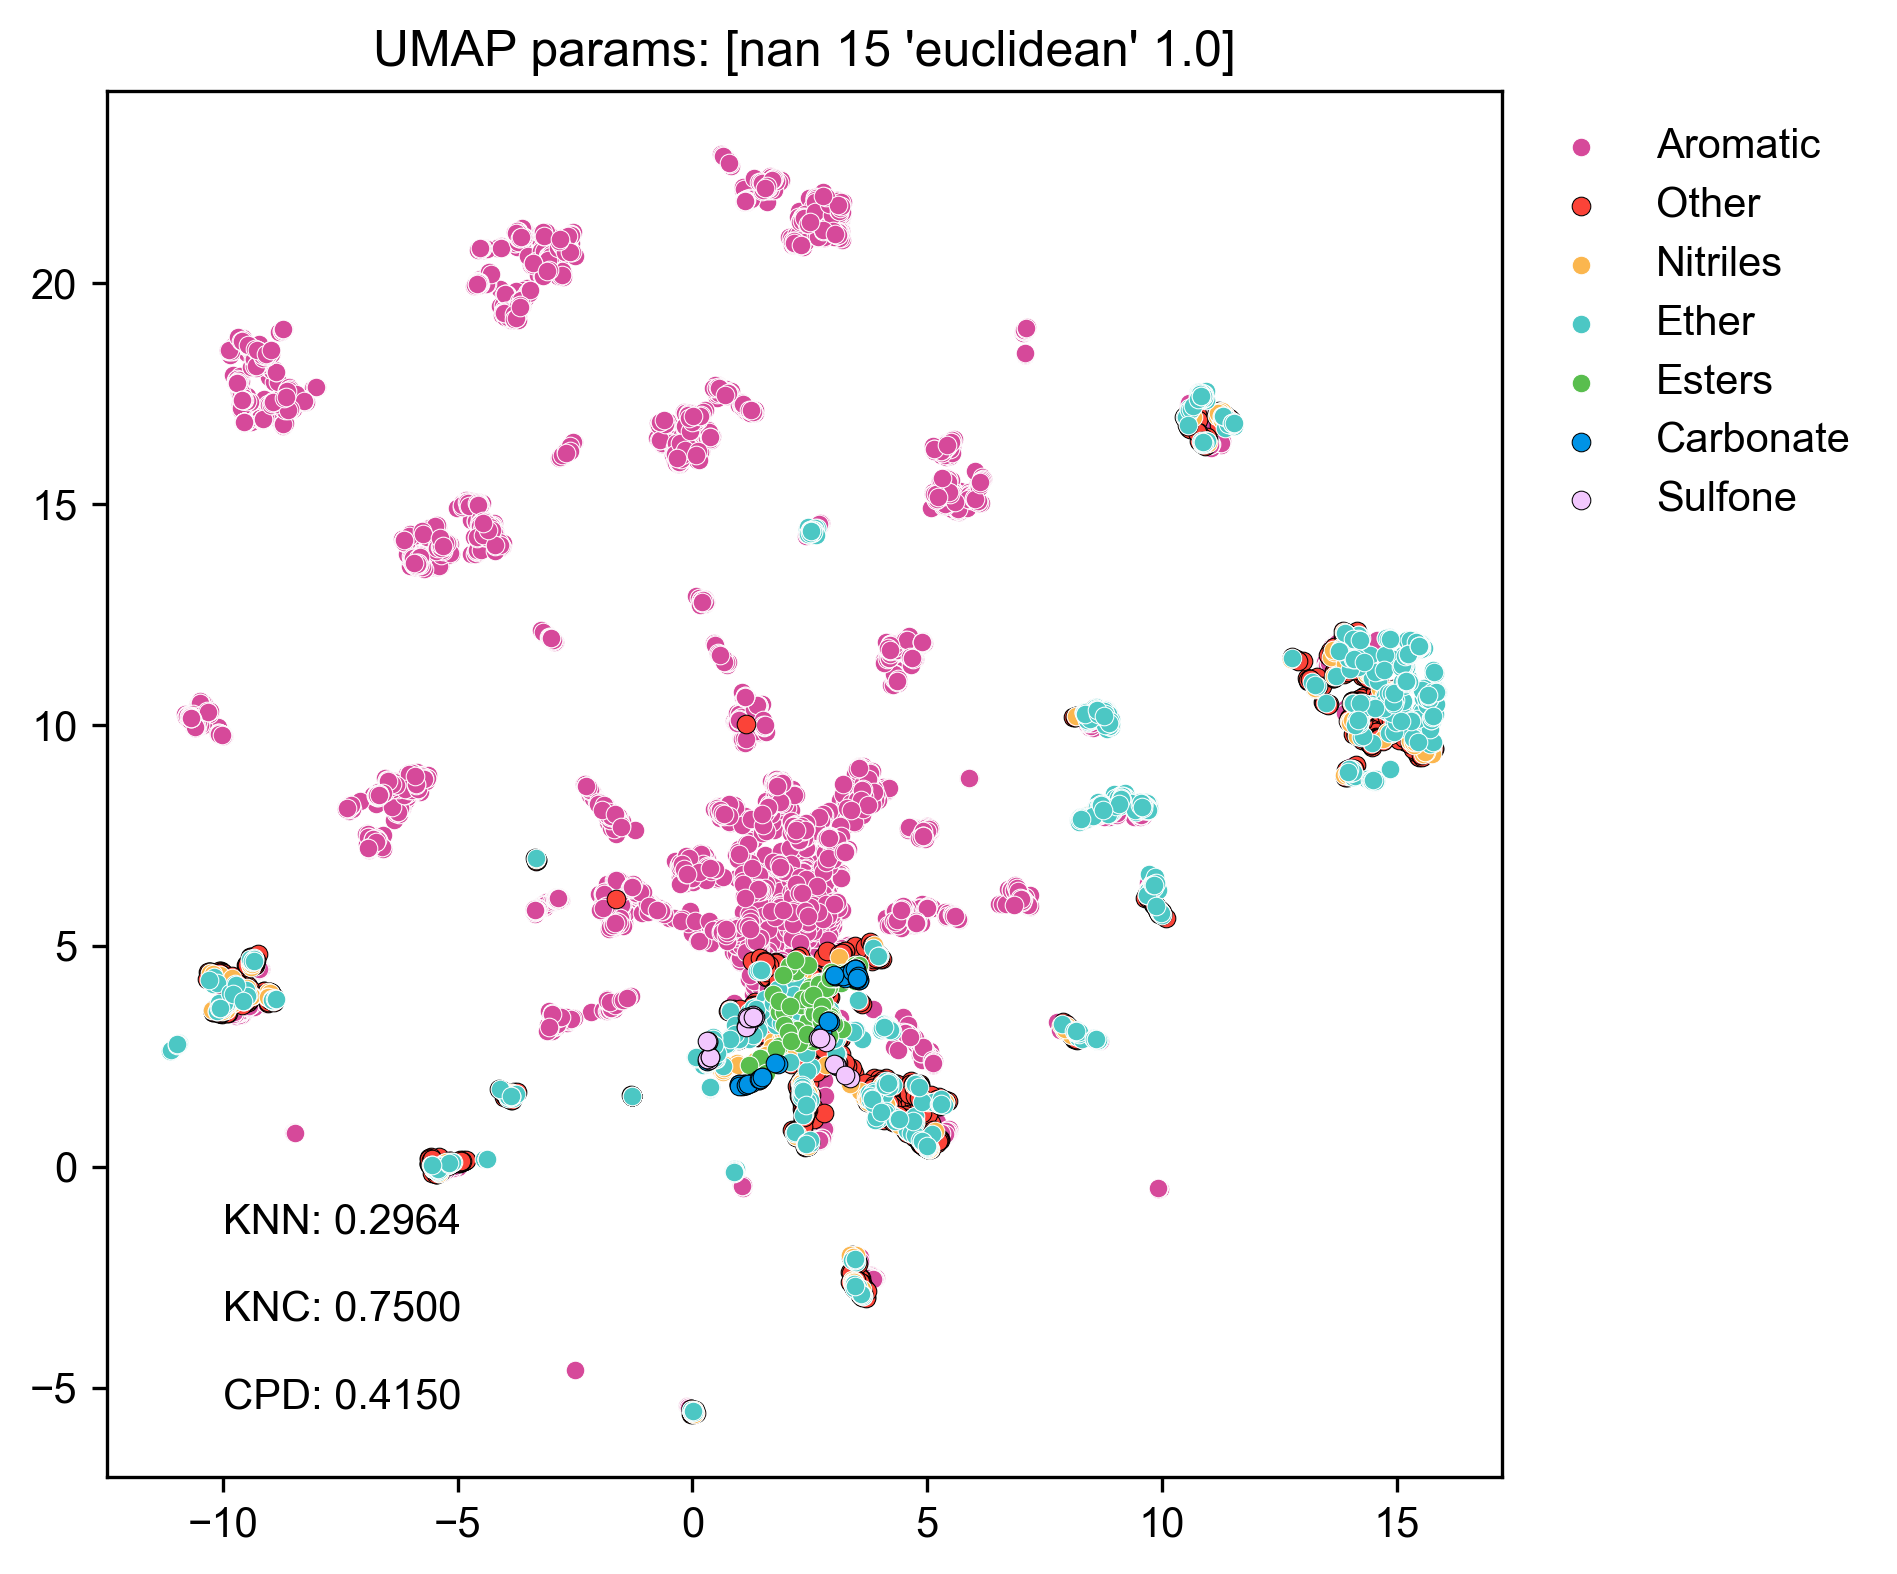

In [120]:
trial = 'default'
# X_umap = np.load('./X_umap_trial_{}.npy'.format(trial), allow_pickle=True)
# df['tnse_0'] = X_tsne[:,0]
# df['tnse_1'] = X_tsne[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
# plt.title("UMAP params: {}".format(df_param_umap_default[['random_state', 'n_neighbors', 'metric', 'repulsion_strength']].iloc[trial].values))
plt.title("UMAP params: {}".format(df_param_umap_default[['random_state', 'n_neighbors', 'metric', 'repulsion_strength']].iloc[0].values))
classes = ['Aromatic', 'Other', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
colors = [(0.839, 0.286, 0.604), (0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]

edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df_umap_default.loc[df_umap_default['class'] == cls]
    ax.scatter(df_cls['umap_0'], df_cls['umap_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=20)
    i += 1
plt.text(-10, -1.5, 'KNN: {:.4f}'.format(df_param_umap_default['knn'][0]), family='Arial', size=10, color='black')
plt.text(-10, -3.5, 'KNC: {:.4f}'.format(df_param_umap_default['knc'][0]), family='Arial', size=10, color='black')
plt.text(-10, -5.5, 'CPD: {:.4f}'.format(df_param_umap_default['cpd'][0]), family='Arial', size=10, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('umap_trial_default_open.eps', dpi=300, bbox_inches='tight')

save PCA plot using default hyper as eps

In [121]:
df_pca_default = pd.read_csv('pca_default_m3.csv')
df_pca_default

smiles  mean_property_value   database      class     pca_0  \
0        C(C#CC(C)C)(C)C             5.481535  MP_oxstab      Other -0.504712   
1                C(=O)=O             9.433272  MP_oxstab      Other -0.795913   
2                      O             7.902121  MP_oxstab      Other -0.683332   
3          C(=C\C)/C(C)C             5.085723  MP_oxstab      Other -0.462746   
4      c1(c(ccc(c1)C)C)C             4.733493  MP_oxstab   Aromatic -0.314697   
...                  ...                  ...        ...        ...       ...   
18383       O=C1OCC(F)O1             0.977029      EDB_2  Carbonate -0.921174   
18384          O=C1OCCO1             0.909369      EDB_2  Carbonate -0.804745   
18385              O=C=O             0.999000      EDB_2      Other -0.795913   
18386      O=S1(=O)CCCC1             0.985000      EDB_2    Sulfone -0.917308   
18387          O=c1occo1             0.968000      EDB_2   Aromatic -0.619403   

          pca_1  
0      0.235455  
1      0.092241  
2      0.101762  
3      0.216475  
4     -0.235849  
...         ...  
18383 -0.088111  
18384 -0.108550  
18385  0.092241  
18386  0.121565  
18387 -0.207954  

[18388 rows x 6 columns]

In [123]:
df_param_pca_default = pd.read_csv('param_pca_default_m3.csv')
df_param_pca_default

random_state svd_solver  whiten       knn       knc      cpd  \
0           NaN       auto   False  0.087399  0.571429  0.56205   

   Carbonate_Esters  Carbonate_Ether  Carbonate_Sulfone  Carbonate_Nitriles  \
0          0.077359          0.60322           0.172129            0.650386   

   ...  Ether_Sulfone  Ether_Nitriles  Ether_Aromatic  Ether_Other  \
0  ...       0.047279        0.107371        0.238966     0.126965   

   Sulfone_Nitriles  Sulfone_Aromatic  Sulfone_Other  Nitriles_Aromatic  \
0          0.520165          0.619574       0.550059           0.347989   

   Nitriles_Other  Aromatic_Other  
0        0.034937        0.051337  

[1 rows x 27 columns]

In [126]:
trial = 'default'
# X_umap = np.load('./X_umap_trial_{}.npy'.format(trial), allow_pickle=True)
# df['tnse_0'] = X_tsne[:,0]
# df['tnse_1'] = X_tsne[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
# plt.title("UMAP params: {}".format(df_param_umap_default[['random_state', 'n_neighbors', 'metric', 'repulsion_strength']].iloc[trial].values))
plt.title("PCA params: {}".format(df_param_pca_default[['random_state', 'svd_solver', 'whiten']].iloc[0].values))
classes = ['Aromatic', 'Other', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
colors = [(0.839, 0.286, 0.604), (0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]

edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df_pca_default.loc[df_pca_default['class'] == cls]
    ax.scatter(df_cls['pca_0'], df_cls['pca_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=20)
    i += 1
plt.text(-1.5, -1.75, 'KNN: {:.4f}'.format(df_param_pca_default['knn'][0]), family='Arial', size=10, color='black')
plt.text(-1.5, -2.00, 'KNC: {:.4f}'.format(df_param_pca_default['knc'][0]), family='Arial', size=10, color='black')
plt.text(-1.5, -2.25, 'CPD: {:.4f}'.format(df_param_pca_default['cpd'][0]), family='Arial', size=10, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('pca_trial_default.eps', dpi=300, bbox_inches='tight')

**Finding MCS**

In [54]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image

# Load molecules using SMILES strings
# mol1 = Chem.MolFromSmiles('CCO')
mol2 = Chem.MolFromSmiles('CCCOCCC') ## DPE
# mol1 = Chem.MolFromSmiles('CCOCCOCC')
# mol2 = Chem.MolFromSmiles('CCCO')
mol1 = Chem.MolFromSmiles('COCCOC') ## DME

# Find the maximum common substructure (MCS)
mcs = rdFMCS.FindMCS([mol1, mol2])

# Convert MCS result to an RDKit molecule
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)

print(f"Common substructure: {Chem.MolToSmiles(mcs_mol)}")

Common substructure: CCOC


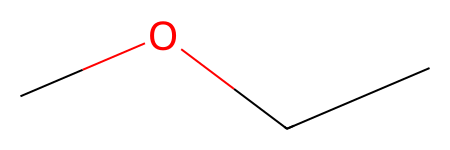

In [55]:
mcs_mol

In [49]:
## do not use this

# Find the atoms in mol2 that match the common substructure
match_atoms = mol2.GetSubstructMatch(mcs_mol)

# Draw mol2 with the common substructure highlighted
img = Draw.MolToImage(mol2, highlightAtoms=match_atoms)
img.show()

In [72]:
# Find the atoms in mol2 that match the common substructure
match_atoms = mol2.GetSubstructMatch(mcs_mol)

# Find the bonds in mol2 that are between the matched atoms
match_bonds = [mol2.GetBondBetweenAtoms(i, j).GetIdx() 
               for i, j in zip(match_atoms[:-1], match_atoms[1:])]

# Define colors for highlighting (in RGB format)
color = (1, 0, 0)  # Red color
color = blue

# Create dictionaries that map atom and bond indices to colors
highlight_atom_colors = {atom: color for atom in match_atoms}
highlight_bond_colors = {bond: color for bond in match_bonds}

# Create a drawer
drawer = rdMolDraw2D.MolDraw2DSVG(400, 200)

# Set the color of all bonds to black
all_bond_colors = {bond.GetIdx(): (0, 0, 0) for bond in mol2.GetBonds()}  # Black color

# Draw mol2 with the common substructure highlighted
drawer.DrawMolecule(mol2, highlightAtoms=match_atoms, highlightBonds=match_bonds, 
                    highlightAtomColors=highlight_atom_colors, highlightBondColors=highlight_bond_colors)
                    # highlightAtomColors=highlight_atom_colors, highlightBondColors=all_bond_colors)

# Set the atom label font to Arial
drawer.drawOptions().atomLabelFontFace = 'Arial'
# drawer.SetColour((0, 0, 0))

drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:', '')
SVG(svg)
## save the svg file
with open('mcs.svg', 'w') as f:
    f.write(svg)

In [66]:
opts.useDefaultAtomPalette()